miniGAP (in repository)  
currently compartmentalizing this into multiple notebooks

In [1]:
# Import everything immediately
# This looks messy right now. I can sort it by type of packages later
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.random as rand
import time
from ase import Atoms
from ase.calculators.emt import EMT
from ase.calculators.lj import LennardJones
from ase.calculators.morse import MorsePotential
#from xtb.ase.calculator import XTB
from ase.optimize import BFGS
from ase.optimize import MDMin
from ase.io import read
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.nvtberendsen import NVTBerendsen
from ase import units
from dscribe.descriptors import SOAP
from numpy import polyfit
from numpy import poly1d
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
from  tensorflow_probability import distributions as tfd
import gpflow.optimizers as gpopts
from sklearn.preprocessing import StandardScaler
import numpy.random as rand
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
tfk = tfp.math.psd_kernels
from sklearn.metrics import mean_squared_error
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from mpl_toolkits import mplot3d
from matplotlib import cm
from os.path import join

In [2]:
def PrintNoScientificNotation(*x):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [3]:
# For coloring text

# pick a color for text. Remember to use color.END afterwards
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
# create an iterateor of red numbers
class red_numbers():
    def __init__(self, start=0):
        self.itr = iter(color.RED + str(i) + color.END for i in range(start, 1000))
        self.state = start
    def tr(self):
        self.state += 1
        return next(self.itr)

In [2]:
def Distance(x1, x2):
    x1 = np.array(x1); x2 = np.array(x2)
    return np.sqrt(((x1 - x2) ** 2).sum())

def get_bond_lengths(atoms_list):
    return [Distance(*atoms.get_positions()) for atoms in atoms_list]

In [9]:
# Get SOAP descriptor for each structure



def get_dscribe_descriptors(atoms_list, species = ["N"], rcut = 3.2, nmax = 5, lmax = 5, is_global=True, return_derivatives = False):
    atoms_list = ([atoms_list] if isinstance(atoms_list, Atoms) else atoms_list)
    averaging_keyword = "outer" if is_global else "off"
    positions = [atoms.get_positions() for atoms in atoms_list]
    soap = SOAP(average=averaging_keyword,  species=species, periodic=False, rcut=rcut, nmax=nmax, lmax=lmax)
    if return_derivatives:
        return soap.derivatives(atoms_list, positions = positions, method="auto")
    else:
        return soap.create(atoms_list)
#     print(positions)
#     if is_global:
#         print("using averaged")
#         AveragedSoap   = SOAP(average='outer',  species=species, periodic=False, rcut=rcut, nmax=nmax, lmax=lmax)
#         derivatives, descriptors = AveragedSoap.derivatives(atoms_list, positions = positions, method="auto")
#         return descriptors
#     else:
#         UnAveragedSoap   = SOAP(average='off',  species=species, periodic=False, rcut=rcut, nmax=nmax, lmax=lmax)
#         derivatives, descriptors = UnAveragedSoap.derivatives(atoms_list, positions = positions, method="auto")
#         return descriptors

In [10]:
# Breakdown of the derivatives output tensor from soap.derivatives(). This explains what the different indices mean in different situations

print_soap_derivatives_tensor_breakdown = False

if print_soap_derivatives_tensor_breakdown:

    use_atom_centers = True
    use_local_descriptors = True
    n_structures = 5

    averaging_keyword = "off" if use_local_descriptors else "outer"
    my_water_molecule = ase.build.molecule('H2O')
    if n_structures == 1:
        my_atoms_list = my_water_molecule
        print("This breakdown of the derivatives tensor is for a single (1) water molecule.")
    elif n_structures > 1:
        my_atoms_list = [my_water_molecule] * n_structures
        print("This breakdown of the derivatives tensor is for {} water molecules.".format(n_structures))
        print("To access the tensor values without defining a tensor for each molecule, add an extra index in front. I didn't do this here because it was easier not to.")


    soap = SOAP(average=averaging_keyword,  species=["H", "O"], periodic=False, rcut=1.2, nmax=1, lmax=1)

    if use_atom_centers:
        positions = my_water_molecule.get_positions()
    else:
        positions = [[0, 0, 0],[5,2,3]]

    if n_structures == 1:
        positions_list = positions
    elif n_structures > 1:
        positions_list = [positions]*len(my_atoms_list)

    my_soap = soap.create(my_atoms_list)
    derivatives, descriptors = soap.derivatives(my_atoms_list, positions=positions_list , method="auto")
    
    print("")

    for k in range(n_structures):
        if n_structures == 1:
            derivative_k = derivatives
            print("For the water molecule soap.derivatives() output, D (soap derivatives) and S (soaps):")
        elif n_structures > 1:
            derivative_k = derivatives[k]
            print("For water molecule #{} soap.derivatives() output, D (soap derivatives) and S (soaps):".format(k))
        for i in range(len(derivative_k)):
            print("---------------------------------------------------------------------------------------------")
            print("---------------------------------------------------------------------------------------------")
            if use_local_descriptors:
                atom_i = "atom " + my_water_molecule[i].symbol + str(my_water_molecule[i].index) + " " if use_atom_centers else ""
                print("D[{}] = derivatives of S[{}], a local soap descriptor centered at {}({:5.2f}, {:5.2f}, {:5.2f})".format(i, i, atom_i, *positions[i]))
            else:
                print("D[{}] = derivative of S[{}], the global soap descriptor averaged over {} centers".format(i, i, len(positions[i])))
            print("---------------------------------------------------------------------------------------------")
            print("---------------------------------------------------------------------------------------------")
            for j in range(len(my_water_molecule)):
                atom_j = my_water_molecule[j].symbol + str(my_water_molecule[j].index)
                print("D[{}, {}] = derivative of S[{}] with respect to atom {} positions".format(i, j, i, atom_j))
                print("--------------------------------------------------------------")

                print("D[{}, {}, {}] = dS[{}]/dX{}: ".format(i, j, 0, i, j), "[" + "  ".join(["{:7.4f}".format(p) for p in derivative_k[i,j,0]]) + "]")
                print("D[{}, {}, {}] = dS[{}]/dY{}: ".format(i, j, 1, i,j), "[" + "  ".join(["{:7.4f}".format(p) for p in derivative_k[i,j,1]]) + "]")
                print("D[{}, {}, {}] = dS[{}]/dZ{}: ".format(i, j, 2, i,j), "[" + "  ".join(["{:7.4f}".format(p) for p in derivative_k[i,j,2]]) + "]")
                #print("")
                print("--------------------------------------------------------------\n")



In [11]:
def RegularizeData(data):
    data = np.array(data)
    if len(data.shape) == 1:
        data_min = np.min(data)
        data_max = np.max(data)
    elif len(data.shape) == 2:
        data_min = np.min(data, axis=1).reshape(len(data), 1)
        data_max = np.max(data, axis=1).reshape(len(data), 1)
    else:
        print("This functionis not able to regularize data of the shape {}".format(data.shape))
    small_number = 10 ** -6 # 0 causes problems
    return (data - data_min)/(data_max - data_min) + small_number

def UnRegularizeData(data, old_data):
    data = np.array(data); old_ta = np.array(old_data)
    if len(data.shape) == 1 and len(old_data.shape) == 1:
        old_data_min = np.min(old_data)
        old_data_max = np.max(old_data)
    else:
        print("This functionis not able to regularize data of the shape {}".format(data.shape))
    small_number = 10 ** -6 # 0 causes problems
    return (data - small_number) * (old_data_max - old_data_min) + old_data_min

In [12]:


class PolynomialRegressionModel:
    def __init__(self, order):
        self.order = order
        
    def fit(self, xs, ys):
        xs = np.array(xs)
        if len(xs.shape) == 2:
            self.xs = np.mean(xs, axis=1)
        elif len(xs.shape) == 1:
            self.xs = xs
        else:
            return
        self.regularized_xs = RegularizeData(self.xs)
        self.ys = ys
        self.polynomial_coefficients = polyfit(self.regularized_xs, self.ys, self.order)
        self.regression_model = poly1d(self.polynomial_coefficients)
        return self#.regression_model
    
    def predict(self, test_x):
        test_x = np.array(test_x)
        if len(test_x.shape) == 2:
            self.test_x = np.mean(test_x, axis=1)
        elif len(test_x.shape) == 1:
            self.test_x = test_x
        else:
            return
        self.test_x_regularized = RegularizeData(self.test_x)
        return self.regression_model(self.test_x_regularized)

In [13]:

class GaussianProcessRegressionModel_saveable(tfd.GaussianProcessRegressionModel):
    def __init__(self,  kernel,index_points, observation_index_points, observations, observation_noise_variance, jitter):#  test_xs, xs, ys,observation_noise_variance):
        super(GaussianProcessRegressionModel_saveable, self).__init__(kernel, index_points, observation_index_points,
                                                                      observations, observation_noise_variance, jitter=jitter)# kernel, test_xs, xs, ys,observation_noise_variance)
    
    @tf.function()
    def mean_compiled(self):
        return self.mean()
        
        
class TensorflowGaussianProcessRegressionModel():
    def __init__(self,  sps, dsps_dr, ens, frcs, test_sps, test_dsps_dr, test_ens, test_frcs, 
                 amplitude_init = .1, length_scale_init = .1, noise_init = 1e-5, jitter = 1e-6, verbose=False):
        self.verbose=verbose
        
        # Rescale sps
        print(sps.shape)
        self.sps_scaler = StandardScaler().fit(sps)
        self.sps, self.test_sps = self.sps_scaler.transform(sps), self.sps_scaler.transform(test_sps)
        self.dsps_dr = dsps_dr / self.sps_scaler.scale_[None, None, None, :]
        self.test_dsps_dr = test_dsps_dr / self.sps_scaler.scale_[None, None, None, :]

        # Also rescale energies and forces
        self.ens_scaler = StandardScaler().fit(ens[:,None])
        self.ens, self.test_ens = self.ens_scaler.transform(ens[:,None])[:,0], self.ens_scaler.transform(test_ens[:,None])[:,0]
        self.frcs = frcs / self.ens_scaler.scale_
        self.test_frcs = test_frcs / self.ens_scaler.scale_

        # Calculate variance for weighting mse_2factor
        self.ens_var = self.ens.var()
        self.frcs_var = self.frcs.var()
        
        self.sps_tf = tf.constant(self.sps, dtype=np.float64)
        self.dsps_dr_tf = tf.constant(self.dsps_dr, dtype=np.float64)
        self.ens_tf = tf.constant(self.ens, dtype=np.float64)
        self.frcs_tf = tf.constant(self.frcs, dtype=np.float64)        
        self.test_sps_tf = tf.constant(self.test_sps, dtype=np.float64)
        self.test_dsps_dr_tf = tf.constant(self.test_dsps_dr, dtype=np.float64)
        self.test_ens_tf = tf.constant(self.test_ens, dtype=np.float64)
        self.test_frcs_tf = tf.constant(self.test_frcs, dtype=np.float64)      
        
        self.constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
        # kernel hyperparameters
        self.observation_noise_variance = tfp.util.TransformedVariable(
            initial_value=noise_init, bijector=self.constrain_positive, dtype=np.float64, 
            name='observational_noise_variance')        
        self.amplitude = tfp.util.TransformedVariable(
            initial_value=amplitude_init, bijector=self.constrain_positive, dtype=np.float64,
            name='amplitude')
        self.length_scale = tfp.util.TransformedVariable(
            initial_value=length_scale_init, bijector=self.constrain_positive, dtype=np.float64,
            name='length_scale')
        self.kernel = tfk.ExponentiatedQuadratic( amplitude=self.amplitude, length_scale=self.length_scale, name = "kernel")

        
        self.trainable_variables = [var.variables[0] for var in [self.amplitude,
                                                                 self.length_scale, 
                                                                 self.observation_noise_variance]]
        
        self.jitter = tf.constant(jitter, dtype=np.float64)
        
        self.batch_error_history = []
        #self.full_loss_history = []
        self.hyperparam_history = []
        
    def fit(self, batch_size_max=30, batch_size_nll=3, 
            n_epochs=10, n_epochs_nll = 3, 
            learn_rate=0.05, shuffle_seed=1, valid_seed = 1, valid_fract=0.75):
        self.n_epochs = n_epochs
        
        if self.n_epochs:
            #self.optimizer = gpopts.Scipy()
            #self.optimizer = gpopts.NaturalGradient()
            #self.optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
            
            # Train with negative log likelihood for a few epochs
            # This reduces the chance of getting stuck in a bad local minimum of 
            # hsperparameters if hyperparameters have bad initial values
            # Only use energies here, no forces

            batches_nll = (tf.data.Dataset.from_tensor_slices((self.sps_tf, self.ens_tf))
                                    .shuffle(buffer_size=len(self.sps), seed=shuffle_seed)
                                    .repeat(count=None)
                                    .batch(batch_size_nll))
            iterations_per_epoch = int(len(self.ens)/ batch_size_nll)
            for j in range(n_epochs_nll):
                for i, (sps_i, ens_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
                    with tf.GradientTape() as tape:
                        loss_i = self.gp_method_nll(sps_i, ens_i)
                        loss_i = tf.constant(loss_i, dtype=np.float64)
                    grads = tape.gradient(loss_i, self.trainable_variables)
                    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            
            # Train on mse of forces and energies
            # We predict forces with f = -dE/dsoap * dsoap/dr
            for j in range(self.n_epochs):
                split_data_j = train_test_split(self.sps, self.ens, self.dsps_dr, self.frcs, random_state =valid_seed +j, test_size=(1-valid_fract))
                sps_j, valid_sps_j, ens_j, valid_ens_j, dsps_dr_j, valid_dsps_dr_j, frcs_j, valid_frcs_j = split_data_j
                
                sps_j_tf = tf.constant(sps_j, dtype= np.float64)
                valid_sps_j_tf = tf.constant(valid_sps_j, dtype=np.float64)
                ens_j_tf = tf.constant(ens_j, dtype=np.float64)
                
                
                if len(sps_j) < batch_size_max:
                    iterations_per_epoch = 1
                    batch_size = len(sps_j)
                else:
                    iterations_per_epoch = int(np.ceil(len(sps_j)/batch_size_max))
                    batch_size = int(np.ceil(len(sps_j)/iterations_per_epoch))

                batches_j = (
                    tf.data.Dataset.from_tensor_slices((sps_j_tf, ens_j_tf, dsps_dr_j, frcs_j)) 
                    .shuffle(buffer_size=len(sps_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
                    .repeat(count=None)
                    .batch(batch_size)
                )
                
                # frcs_j_i might be extraneous unless we learn forces directly
                for i, (sps_j_i, ens_j_i, dsps_j_i, frcs_j_i) in enumerate(islice(batches_j, iterations_per_epoch)):
                    with tf.GradientTape() as tape:
                        with tf.GradientTape(watch_accessed_variables=False) as tape_dens_dsps:
                            tape_dens_dsps.watch(valid_sps_j_tf)    
                            gprm_j_i = tfd.GaussianProcessRegressionModel(
                                kernel = self.kernel,
                                index_points = valid_sps_j_tf,
                                observation_index_points = sps_j_i,
                                observations = ens_j_i,
                                observation_noise_variance = self.observation_noise_variance)
                            predict_ens_j_i = gprm_j_i.mean()
                        predict_dens_dsps_j_i = tape_dens_dsps.gradient(predict_ens_j_i, valid_sps_j_tf)
                        predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', valid_dsps_dr_j, predict_dens_dsps_j_i)#[:,1] # only get force of one atom while we are doing global soap
                        error_j_i = self.mse_2factor(predict_ens_j_i, valid_ens_j, 1/self.ens_var, predict_frcs_j_i, valid_frcs_j, 1/self.frcs_var)
                    grads = tape.gradient(error_j_i, self.trainable_variables)
                    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
                    self.batch_error_history.append((j*iterations_per_epoch + i, error_j_i))
                self.hyperparam_history.append([(j, self.constrain_positive(var).numpy()) for var in self.trainable_variables])
        else:
            # I could allow for collection of full mse error here (and also in the j for loop)
            # but this is low priority
            pass
        
        return self
    
    # Use tf.function for more efficient function evaluation
    # I do not know why we turn autograph off or what experimental_compile does
    @tf.function(autograph=False, experimental_compile=False) 
    def gp_method_nll(self, xs, ys):
        """Gaussian process negative-log-likelihood loss function."""
        if self.verbose:
            print("Now tracing TensorflowGaussianProcessRegressionModel.gp_method_nll()")
        gp = tfd.GaussianProcess(
            kernel=self.kernel,
            index_points=xs,
            observation_noise_variance=self.observation_noise_variance, 
            jitter=self.jitter
        )
        return -gp.log_prob(ys)
    
    @tf.function(autograph=False, experimental_compile=False)
    def mse(self, y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(self, y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = self.mse(y1_predict, y1_true)
        mse2 = self.mse(y2_predict, y2_true)
        return mse1 * weight1 + mse2 * weight2
    
    
    def plot_learning(self, color="blue", fontsize=14, title="Learning"):
        matplotlib.rc('font', size=fontsize)
        fig, [[ax00, ax01], [ax10, ax11]] = plt.subplots(nrows=2, ncols = 2, figsize=(16,12))
        
        # hyperparameters on axes 00, 01, 10
        amplitudes, lengths, noises = np.swapaxes(self.hyperparam_history, 0, 1)
                                               
        ax00.plot(*zip(*amplitudes), color=color)
        ax00.plot(*amplitudes[-1], "o", color=color)
        ax00.set_ylabel("kernel ampliutude")
        #ax00.set_yscale('log')
        annotation00 = ax00.annotate('{:.1f}'.format(amplitudes[-1][1]) , xy=amplitudes[-1], xycoords='data', xytext=(-30,100),
                                     textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
                                               
        ax01.plot(*zip(*lengths), color=color)
        ax01.plot(*lengths[-1], "o", color=color)
        ax01.set_ylabel("kernel length scale")
        #ax01.set_yscale('log')
        annotation01 = ax01.annotate('{:.1f}'.format(lengths[-1][1]) , xy=lengths[-1], xycoords='data', xytext=(100,-30), 
                                     textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
                                               
        ax10.plot(*zip(*noises), color=color)
        ax10.plot(*noises[-1], "o", color=color)
        ax10.set_ylabel("kernel observational noise variance")
        ax10.set_yscale('log')
        annotation01 = ax10.annotate('{:.1e}'.format(noises[-1][1]) , xy=noises[-1], xycoords='data', xytext=(-30,100),
                                     textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
                                               
        # loss on axis 11
        ax11.plot(*zip(*self.batch_loss_history), color=color)#, label="batch")
        ax11.plot(*self.batch_loss_history[-1], "o", color=color)
        ax11_twin = ax11.twinx()
        ax11_twin.plot(*zip(*self.full_loss_history), "--", color = "k", label="full")
        ax11_twin.plot(*self.full_loss_history[-1], "o", color="k")
        bottom, top = ax11.get_ylim()
        bottom2, top2 = ax11_twin.get_ylim()
        x, y = self.batch_loss_history[-1]
        y = bottom2 + (y- bottom)/(top - bottom)*(top2 - bottom2)
        annotation = ax11_twin.annotate('{:.0f}'.format(self.batch_loss_history[-1][1]) , xy=(x, y), xycoords='data', xytext=(100,30),
                                        textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'})
        annotation2 = ax11_twin.annotate('{:.0f}'.format(self.full_loss_history[-1][1]) , xy=self.full_loss_history[-1], xycoords='data', xytext=(30,-100),
                                         textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'})
        ax11.set_ylabel("batch negative log likelihood")
        ax11_twin.set_ylabel("full negative log likelihood", rotation=-90, labelpad=15)
        #ax11.legend()
        ax11_twin.legend()

    def predict(self, redundant_test_sps):        
        self.regression_model = tfd.GaussianProcessRegressionModel(
                                        kernel=self.kernel,
                                        index_points=self.test_sps_tf,
                                        observation_index_points=self.sps_tf,
                                        observations=self.ens_tf,
                                        observation_noise_variance=self.observation_noise_variance)
        self.predict_ens = self.regression_model.mean()
        return self.predict_ens


    def predict_ens_and_frcs(self, redundant_test_sps):        
        with tf.GradientTape(watch_accessed_variables=False) as tape_dens_dsps:
            tape_dens_dsps.watch(self.test_sps_tf)    

            self.regression_model = tfd.GaussianProcessRegressionModel(
                                        kernel=self.kernel,
                                        index_points=self.test_sps_tf,
                                        observation_index_points=self.sps_tf,
                                        observations=self.ens_tf,
                                        observation_noise_variance=self.observation_noise_variance)

            self.predict_ens = self.regression_model.mean()

        self.predict_dens_dsps = tape_dens_dsps.gradient(self.predict_ens, self.test_sps_tf)
        self.predict_frcs = -1*np.einsum('imjkl,il->ijk', self.test_dsps_dr_tf, self.predict_dens_dsps)#[:,1] # only get force of one atom while we are doing global soap

        return (self.predict_ens, self.predict_frcs)




The following function, LearnEnergyFromSoap:  
    - Takes soap descriptors and energies as input.  
    - Splits this data into test and training sets  
    - Trains a regression model on the training set  
        -- Can be sklearn gaussian processors, tensorflow gaussian processes or linear fit  
    - Returns the model and split data  

In [14]:


def LearnEnergyFromSoap(soap_list, energy_list, training_fraction=0.7, verbose=False, kernel_type="RBF", model_type="GP_sklearn",
                        split_seed = 1, learn_seed = 1, gamma = 1, order = 0, is_global = True,
                        batch_size=30, n_epochs=5, learn_rate=0.05,
                        noise_init = 1e-10, amplitude_init = 1, length_scale_init = 1, jitter=1e-6):
#     # For consistency we start with the same random seed everytime (used for partitioning step)
#     rand.seed(1)    
#     # Partition the soap and energy data into training and test groups
#     train_N = int(training_fraction * len(energy_list))
#     train_indices = rand.choice(range(len(energy_list)), size=train_N, replace=False)  
#     train_sps = [soap_list[i] for i in train_indices]
#     train_ens = [energy_list[i] for i in train_indices]
#     test_indices = [i for i in range(len(energy_list)) if i not in train_indices]
#     test_sps = [soap_list[i] for i in test_indices]
#     test_ens = [energy_list[i] for i in test_indices]

    if not is_global:
        energy_list = np.repeat(np.array(energy_list)/soap_list.shape[1], soap_list.shape[1])#, dtype=np.float64) 
        soap_list = np.reshape(soap_list, (soap_list.shape[0] * soap_list.shape[1], soap_list.shape[2]))

    
    train_sps, test_sps, train_ens, test_ens = train_test_split(soap_list, energy_list, random_state=split_seed,
                                                                test_size=(1-training_fraction))
    #split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, 
    #                          random_state=split_seed, test_size=(1-training_frac))
    #train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs = split_data
    
    if verbose:
        print("Initiating model training")
    
    if model_type == "GP_sklearn":
        if kernel_type == "RBF":
            rbf_kernel = RBF(length_scale=1/(2 * gamma )** 0.5, length_scale_bounds=(1e-4, 1e6))
            if verbose:
                median_element = np.median(rbf_kernel(train_sps).flatten())
                if median_element == 0 or median_element == 1:
                    print("Warning: This kernel may not be a good fit for this data")
                    print("Problem kernel[:4]:")
                    print(rbf_kernel(train_sps[:4]))
        else:
            print("This function does not currently support the kernel type '{}'".format(kernel_type))
            return
        regression_model = GaussianProcessRegressor(kernel=rbf_kernel).fit(train_sps, train_ens)
    elif model_type == "Polynomial":
        regression_model = PolynomialRegressionModel(order=order).fit(train_sps, train_ens)
    elif model_type == "GP_Tensorflow":
        regression_model = TensorflowGaussianProcessRegressionModel(train_sps, train_ens, test_sps, amplitude_init, length_scale_init,  
                                                                    noise_init, jitter, verbose)\
                           .fit(batch_size, n_epochs, learn_rate, learn_seed)
    else:
        print("This function does not currently support the model type '{}'".format(model_type))
        return

    return regression_model, test_sps, test_ens, train_sps, train_ens

In [15]:
def LearnFromSoap(soap_list, dsoap_dr_list, energy_list, force_list,
                  training_fraction=0.7, valid_fraction = 0.7, verbose=False, model_type="GP_sklearn",
                        split_seed = 1, learn_seed = 1, valid_seed = 1, is_global = False, learn_forces = True,
                        batch_size_max=30, n_epochs=5, learn_rate=0.05,
                        noise_init = 1e-10, amplitude_init = 1, length_scale_init = 1, jitter=1e-6):
    if is_global:
        print("This program cannot compute forces with global soaps")
        return
    
    #energy_list = np.repeat(np.array(energy_list)/soap_list.shape[1], soap_list.shape[1])#, dtype=np.float64) 
    #print(soap_list.shape)
    #soap_list = np.reshape(soap_list, (soap_list.shape[0] * soap_list.shape[1], soap_list.shape[2]))
    #print(soap_list.shape)
    #soap_list = soap_list.reshape(len(soap_list),-1)
    soap_list = soap_list[:,0,:]


    #energy_list = RegularizeData(energy_list)
    
    print([x.shape for x in [soap_list, dsoap_dr_list, energy_list, force_list]])

    split_data = train_test_split(soap_list, dsoap_dr_list, energy_list, force_list, random_state=split_seed,
                                                                test_size=(1-training_fraction))
    train_sps, test_sps, train_dsps_dr, test_dsps_dr, train_ens, test_ens, train_frcs, test_frcs = split_data
    
    if verbose:
        print("Initiating model training")
    
    if model_type == "GP_Tensorflow":
        regression_model = TensorflowGaussianProcessRegressionModel(train_sps, train_dsps_dr, train_ens, train_frcs, test_sps,  test_dsps_dr, test_ens, test_frcs, 
                                                                    amplitude_init, length_scale_init, noise_init, jitter, verbose)\
                           .fit(batch_size_max=batch_size_max, n_epochs=n_epochs, learn_rate=learn_rate, shuffle_seed=learn_seed, valid_seed = valid_seed, valid_fract=valid_fraction)
    else:
        print("This function does not currently support the model type '{}'".format(model_type))
        return

    return regression_model, test_sps, test_dsps_dr, test_ens, test_frcs, train_sps, train_dsps_dr, train_ens, train_frcs



In [16]:
# This function:
#     - Plots predicted energies vs actual energies

def PlotPredictedEnergies(actual_energies, predicted_energies, all_energies = [], title="", show=True):
    if show:
        plt.cla()
    all_energies = [ *actual_energies, *predicted_energies, *all_energies]
    min_energy = min(all_energies); max_energy = max(all_energies)
    plt.plot([min_energy, max_energy], [min_energy, max_energy], "-k")
    plt.plot(actual_energies, predicted_energies, "o")
    plt.xlabel("Actual Test Energies")
    plt.ylabel("Energies Predicted by Regression Model")
    plt.title(title)
    if show:
        plt.show()
    

In [17]:



def GetErrorFromModel(model, test_xs, test_ys, error_types = "absolute"):
    predicted_ys = model.predict(test_xs)
    
    if type(error_types) == str:
        error_types = [error_types]
    
    errors = []
    for error_type in error_types:
        if error_type == "absolute":
            error = np.mean(np.abs(test_ys - predicted_ys))
        elif error_type == "rms":
            error = mean_squared_error(test_ys, predicted_ys)#, squared=False)
        elif error_type == "r2":
            error = np.corrcoef(test_ys, predicted_ys)[0,1] **2
        elif error_type == "max":
            error = np.max(np.abs(test_ys - predicted_ys))
        else:
            print("This function does not currently support the error type '{}'".format(error_type))
            return
        errors.append(error)
        
    return errors


 # --------------------------------------------------------------------------------------------------
 # End of functions
 # --------------------------------------------------------------------------------------------------

**Use the cell below to collect error data for multiple models run with diatomic molecules. Use a different cell for plotting.**

In [18]:
# The purpose of this cell is collect error data for later plotting and analysis. The data is stored in Plottable_Model_Errors.
# Many variable can be adjusted, including which model types are trained, which error types are collected and whether the descriptors are global or local.

element="O"; temp=300; train_f = 0.8; learn_seed = 1; split_seed=1; polynomial_order = 6; is_global = False

unique_ns = [300]#[100,200,300]
repeats = 1
ns_list = np.repeat(unique_ns, repeats)

error_types = ["absolute", "rms", "max"]
model_types = ["GP_Tensorflow"]#["GP_sklearn", "GP_Tensorflow"]#, "Polynomial"]
Plottable_Model_Errors = {error_type: {model_type: [] for model_type in model_types} for error_type in error_types}

i = red_numbers(start=1) # generate red numbers starting at 1
soap_type = "global" if is_global else "local"; soap_type = color.BOLD + soap_type + color.END
c = "During each trial, this cell will first ({}) generate a new structural database of {}₂ molecules, then ({}) generate {} SOAP descriptors,\n".format(i.tr(), element, i.tr(), soap_type) + \
    "then ({}) train a new regression model to learn {} energies from {} SOAP descriptors and finally ({}) collect several types of\n".format(i.tr(), soap_type, soap_type, i.tr()) + \
    "learning error which will be stored in Plottable_Model_Errors. To retrieve the error type A for model type B, use Plottable_Model_Errors[A][B].\n" + \
    "error types: {}\nmodel types: {}\n".format(error_types, model_types) + \
    "The number of structures, n, can vary between trials. There will be {} trials for each unique n-value, for a total of {} trials.\n".format(repeats, len(ns_list)) + \
    "unique ns: {}".format(unique_ns)
cell_announcement = c # I used two names here to allow the long strings to fit in the cell more easily
print(cell_announcement)
print("-"*80)

def print_update(append_string=""):
    print("starting ({}){}".format(i.tr(), append_string), end=" ... ")

for n_index in range(len(ns_list)):
    n = ns_list[n_index]
    i = red_numbers(start=1) # generate red numbers starting at 1
    print("Starting n={} trial".format(n), end=" ... ")
    print_update(); AtomsList = generate_md_traj(element=element, verbose=False, nsteps = n-1, temperature=temp, from_diatomic=True)
    EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64)
    ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)
    print_update(); SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=[element], nmax=5, lmax=5, is_global=is_global, return_derivatives=True)
    print(SoapList.shape)
    loop_start_step = i.state
    for model_type in model_types:
        i = red_numbers(start=loop_start_step)
        print_update("-{}".format(model_type))
        Model, TestSList, TestDSList, TestEList, TestFList, TrainSList, TrainDSList, TrainEList, TrainFList = LearnFromSoap(SoapList, SoapDerivativeList, EnergyList, ForceList,
                                                                                                  training_fraction=train_f, is_global=is_global,
                                                                                  verbose=False, model_type=model_type,
                                                                                  split_seed=split_seed, learn_seed = learn_seed,# gamma = 300, order = polynomial_order, kernel_type="RBF", batch_size=30,
                                                                                  n_epochs=1, learn_rate=0.05)
        print_update("-{}".format(model_type))
        Errors = GetErrorFromModel(Model, TestSList, TestEList, error_types=error_types)
        for error_index in range(len(error_types)):
            Plottable_Model_Errors[error_types[error_index]][model_type].append(Errors[error_index]) 
    print("done with this trial ({:3.0%} done overall)".format( (n_index + 1)/len(ns_list)))
print("All done! No issues!")

During each trial, this cell will first (1) generate a new structural database of O₂ molecules, then (2) generate local SOAP descriptors,
then (3) train a new regression model to learn local energies from local SOAP descriptors and finally (4) collect several types of
learning error which will be stored in Plottable_Model_Errors. To retrieve the error type A for model type B, use Plottable_Model_Errors[A][B].
error types: ['absolute', 'rms', 'max']
model types: ['GP_Tensorflow']
The number of structures, n, can vary between trials. There will be 1 trials for each unique n-value, for a total of 1 trials.
unique ns: [300]
--------------------------------------------------------------------------------
Starting n=300 trial ... starting (1) ... starting (2) ... (300, 2, 90)
starting (3)-GP_Tensorflow ... [(300, 90), (300, 2, 2, 3, 90), (300,), (300, 2, 3)]
(240, 90)
Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


2021-08-20 13:26:58.336367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-20 13:26:58.339030: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-08-20 13:26:58.373166: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-08-20 13:26:58.930695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 13:26:58.935199: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 

starting (4)-GP_Tensorflow ... done with this trial (100% done overall)
All done! No issues!


(60, 2, 3) (60, 2, 3)


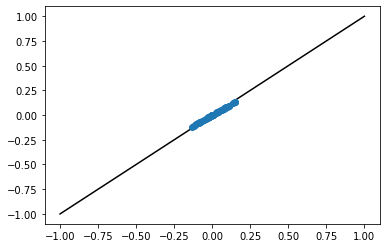

In [19]:
blah, forces = Model.predict_ens_and_frcs([])
forces *= Model.ens_scaler.scale_
print(TestFList.shape, forces.shape)
plt.plot([-1,1],[-1,1], "k")
plt.plot(TestFList[:,0,0], forces[:,0,0], "o")


**Use the cell below to plot error data from Plottable_Model_Errors.**

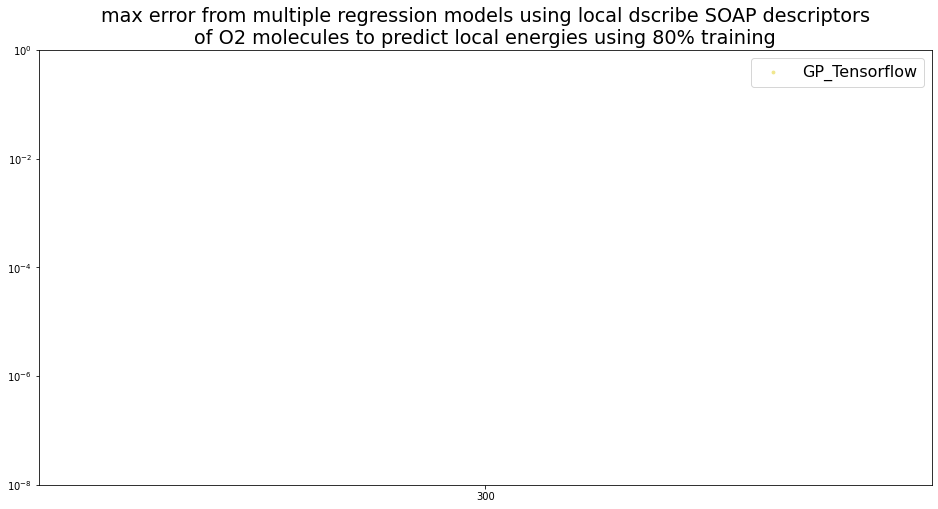

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
model_type_colors = {"GP_Tensorflow":"khaki", "GP_sklearn":"deepskyblue", "Polynomial":"green"}
plotted_error_type = "max"
for model_type in model_types:
    ax.scatter(ns_list, Plottable_Model_Errors[plotted_error_type][model_type], color=model_type_colors[model_type], label=model_type, s=8)
soap_type = "global" if is_global else "local"
title = u"{} error from multiple regression models using {} dscribe SOAP descriptors\nof {}2 molecules to predict {} energies using {:.0%} training".format(plotted_error_type, soap_type, element, soap_type, train_f)
matplotlib.rc('font', size=16)
ax.set_title(title)
ax.legend()
ax.set_yscale('log')
ax.set_xticks(unique_ns)
ax.set_ylim(top=1, bottom=1e-8)
plt.show()

In [21]:
# previous output for different parameters (local descriptors)
Out[115]

KeyError: 115

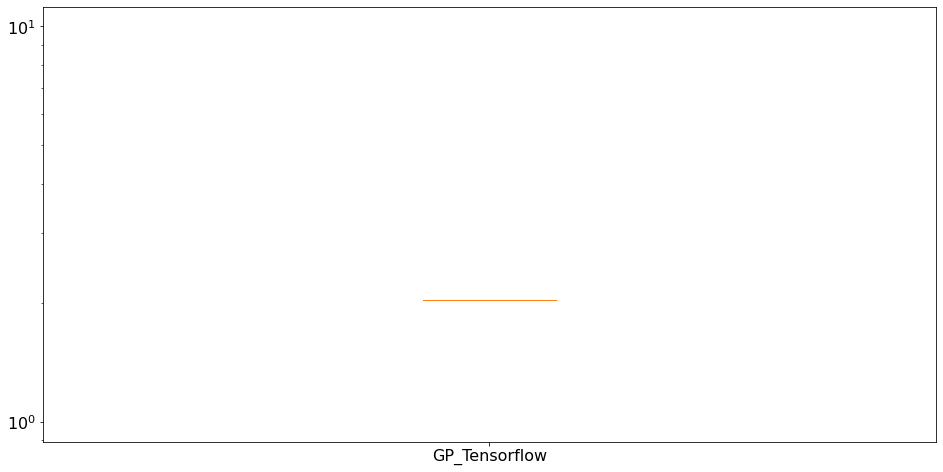

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
model_type_colors = {"GP_Tensorflow":"khaki", "GP_sklearn":"deepskyblue", "Polynomial":"green"}
plotted_error_type = "max"

listed_errors = list(Plottable_Model_Errors[plotted_error_type].values())
boxplot = ax.boxplot(listed_errors, labels=model_types, patch_artist=True)
for i in range(len(model_types)):
    boxplot["boxes"][i].set_facecolor(model_type_colors[model_types[i]])
plt.yscale("log")

# ------------------------------------------------------------------------------------------
# Learning forces
# ------------------------------------------------------------------------------------------

In [23]:
# We need to calculate d(model)/d(descriptors) i.e. the gradient of the model with respect to the input
# This is called an inner tape in tensorflow according to https://www.tensorflow.org/guide/advanced_autodiff
# Okay I'm going to try to record my inner tape
# -----------------------------------------------------------------------------------------------------------
# To make it easy first, we will define an analytically differentiable function and its derivative
# We will generate data from these
# I modified this on 7/12 to prevent it from diverging
A = 100; T=2; phi=2; m=1; L=15; x0 = 15
def f(x):
    return A*tf.math.sin(x/T + phi) + m* x**2 * tf.math.exp(-(x - x0) **2 / (2*L**2))

def dfdx(x):
    return  A/T*np.cos(x/T + phi) + (2 - (x - x0)*x/L**2)*m*x * tf.math.exp(-(x - x0) **2 / (2*L**2))



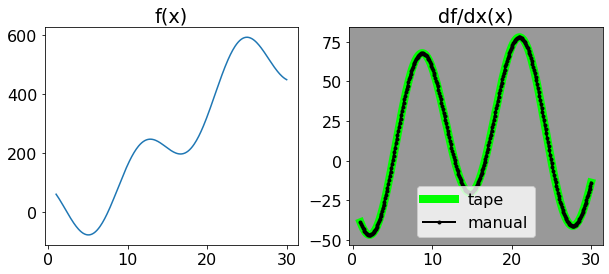

In [24]:
# Without using a regression model yet, we will check to be sure that we can calculate a derivative accurately with tape 
xs = np.linspace(1,30,300, dtype=np.float64)
fs = np.array(f(xs))
dfdxs = dfdx(xs)

xs_tf = tf.Variable(xs, dtype=np.float64)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(xs_tf)
    y = f(xs_tf)
dy_dxs = tape.gradient(y, xs_tf)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (10,4))
ax1.plot(xs, fs)
ax1.set_title("f(x)")
ax2.plot(xs, dy_dxs, "-", label="tape",lw=8, color="lime")
ax2.plot(xs, dfdxs, "-o",label="manual", lw=2, color="black", ms=3)
ax2.set_title("df/dx(x)")
ax2.set_facecolor([.6]*3)
plt.legend();#

gp method integral    = 0.39893745972808264
step by step integral = 0.39893765929679637


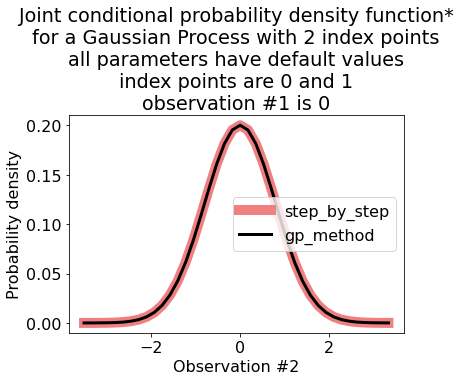

In [25]:
# Here I wrote a function, step_by_step_probability, that replicates the gp.prob() function


# Note to self(7/2 5:36 PM):
#  I think I discovered an error in the tensorflow documentation. They say K but should say K^-1
#  I want to simplify my code to ask this on stack exchange
#  Also should ask why we don't have to use mean_fn
#  Have to take a break because my eyes are hurting and Red Eye closes soon
#  Should respond to Jose soonish


amplitude = tf.constant(1, dtype=np.float64)
length_scale = tf.constant(1, dtype=np.float64)
kernel = tfk.ExponentiatedQuadratic(amplitude=amplitude, length_scale=length_scale)
noise = tf.constant(0, dtype=np.float64)

def step_by_step_probability(index_points, observations):
#     from https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess    
#     pdf(x; index_points, mean_fn, kernel) = exp(-0.5 * y) / Z
#     K = (kernel.matrix(index_points, index_points) + observation_noise_variance * eye(N))
#     y = (x - mean_fn(index_points))^T @ K @ (x - mean_fn(index_points))
#     Z = (2 * pi)**(.5 * N) |det(K)|**(.5)

    N = len(observations)
    K = kernel.matrix(index_points, index_points) + noise * tf.eye(N, dtype=np.float64)
    K_inv = tf.linalg.inv(K)
    row_vec = tf.expand_dims(observations, axis=0)#- predict_fs, axis=0)
    y = row_vec @ K_inv   @ tf.transpose(row_vec) #tf.matmul(tf.matmul(row_vec, K), tf.transpose(row_vec))
    Z = ((2 * np.pi)**(.5 * N)) * (tf.linalg.det(K)**(.5))#tf.constant(1, dtype=np.float64)#((2 * np.pi)**(.5 * N)) * (tf.linalg.det(K)**(.5))
    prob = tf.math.exp(-0.5 * y) /Z
    return prob

def step_by_step_nll(index_points, observations):
#     from https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess    
#     pdf(x; index_points, mean_fn, kernel) = exp(-0.5 * y) / Z
#     K = (kernel.matrix(index_points, index_points) + observation_noise_variance * eye(N))
#     y = (x - mean_fn(index_points))^T @ K @ (x - mean_fn(index_points))
#     Z = (2 * pi)**(.5 * N) |det(K)|**(.5)

    N = len(observations)
    K = kernel.matrix(index_points, index_points) + noise * tf.eye(N, dtype=np.float64)
    K_inv = tf.linalg.inv(K)
    row_vec = tf.expand_dims(observations, axis=0)
    y = row_vec @ K_inv   @ tf.transpose(row_vec) 
    Z = ((2 * np.pi)**(.5 * N)) * (tf.linalg.det(K)**(.5))
    nll = 0.5 * y + np.log(Z)
    return nll


single_index_point = tf.constant([[0], [1]], dtype=np.float64)

gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=single_index_point, observation_noise_variance=noise#, jitter=1#, mean_fn=f
    
    )
max_x = 3.5
xs = np.linspace(-max_x,max_x,41)#+ 220
ys_step_by_step = []
ys_gp_method = []

integral_gp_method = 0
integral_step_by_step = 0
for i in range(len(xs)-1):
    x1 = xs[i]
    single_observation = tf.constant([0,x1], dtype=np.float64)

    l_gp_method = gp.prob(single_observation).numpy()#[0]
    integral_gp_method += (xs[i+1]-x1)* l_gp_method
    nll_gp_method = -gp.log_prob(single_observation).numpy()
    ys_gp_method.append(l_gp_method)


    l_step_by_step = step_by_step_probability(single_index_point, single_observation).numpy()[0][0]
    integral_step_by_step += (xs[i+1]-x1)* l_step_by_step
    nll_step_by_step = step_by_step_nll(single_index_point, single_observation).numpy()[0][0]
    ys_step_by_step.append(l_step_by_step)
    

plt.plot(xs[:-1], ys_step_by_step, label="step_by_step",lw=10, color="lightcoral")
plt.plot(xs[:-1], ys_gp_method, label="gp_method", lw=3, color="black", ms=3)
plt.legend()
plt.xlabel("Observation #2")
plt.ylabel("Probability density")
plt.title("Joint conditional probability density function*\nfor a Gaussian Process with 2 index points\nall parameters have default values\nindex points are 0 and 1\nobservation #1 is 0")
print("gp method integral    = {}".format(integral_gp_method))
print("step by step integral = {}".format(integral_step_by_step))
#print("\n* This is the probability that the second observation has some value with the index points and one of the observations fixed.\nIt is a 1D slice of the 2D probability density surface.")

\* This is the probability that the second observation has some  
value with the index points and one of the observations fixed.  
It is a 1D slice of the 2D probability density surface.

Custom learning, epoch 0
Custom learning, epoch 20
Custom learning, epoch 40
Custom learning, epoch 60
Custom learning, epoch 80
Custom learning, epoch 100
Custom learning, epoch 120
Custom learning, epoch 140
Custom learning, epoch 160
Custom learning, epoch 180
Custom learning, epoch 200
Custom learning, epoch 220
Custom learning, epoch 240
Custom learning, epoch 260
Custom learning, epoch 280
Custom learning, epoch 300
Custom learning, epoch 320
Custom learning, epoch 340
Custom learning, epoch 360
Custom learning, epoch 380
For 1 nll epochs and 399 mse epochs, the custom learning took 1.0 and 22.9 seconds respectively (1.05 and 0.06 s/epoch) for a total of 24.0 seconds
New learning, epoch 0
New learning, epoch 10
New learning, epoch 20
New learning, epoch 30
New learning, epoch 40
New learning, epoch 50
New learning, epoch 60
New learning, epoch 70
For 80 mse epochs, the new learning took 21.9 seconds (0.27 s/epoch)
Old learning, epoch 0
Old learning, epoch 10
Old learning, epoch 2

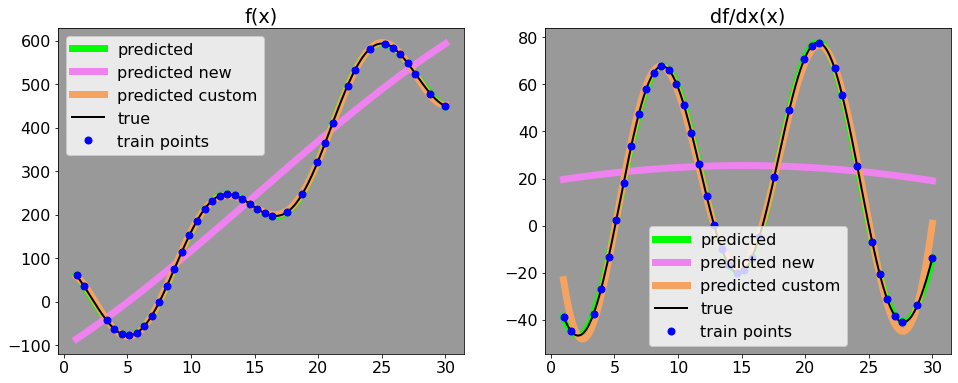

In [26]:
# Next we will try to learn the analytically differentiable function AND its derivatives using a tensor flow gprm
xs = np.linspace(1,30,50, dtype=np.float64)
fs = np.array(f(xs))
dfdxs = np.array(dfdx(xs))
train_fract = 0.8; split_seed = 1; shuffle_seed = 2; batch_size=6; valid_fract=0.8; valid_split_seed=1; mse_batch_size = 100
noise_init=.1; amp_init=3e2; len_init=18
train_xs, test_xs, train_fs, test_fs, train_dfdxs, test_dfdxs = train_test_split(xs, fs, dfdxs, random_state =split_seed, test_size=(1-train_fract))
fs_var = train_fs.var(); dfdxs_var = train_dfdxs.var()

# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# f
f_obs_noise = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="f_noise")#100#0#1e-3
f_amplitude = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="f_amplitude")
f_length_scale = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="f_length_scale")
f_kernel = tfk.ExponentiatedQuadratic(amplitude=f_amplitude, length_scale=f_length_scale)
# f_new
f_obs_noise_new = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="f_noise_new")#100#0#1e-3
f_amplitude_new = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="f_amplitude_new")
f_length_scale_new = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="f_length_scale_new")
f_kernel_new = tfk.ExponentiatedQuadratic(amplitude=f_amplitude_new, length_scale=f_length_scale_new)
# f_custom
f_obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="f_noise_custom")#100#0#1e-3
f_amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="f_amplitude_custom")
f_length_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="f_length_scale_custom")
f_kernel_custom = tfk.ExponentiatedQuadratic(amplitude=f_amplitude_custom, length_scale=f_length_scale_custom)
# dfdx
dfdx_obs_noise = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="dfdx_noise")#100#0#1e-3
dfdx_amplitude = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="dfdx_amplitude")
dfdx_length_scale = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="dfdx_length_scale")
dfdx_kernel = tfk.ExponentiatedQuadratic(amplitude=dfdx_amplitude, length_scale=dfdx_length_scale)
# 
trainable_variables = [var.variables[0] for var in [f_amplitude, f_length_scale, f_obs_noise, 
                                                    dfdx_amplitude, dfdx_length_scale, dfdx_obs_noise]]
trainable_variables_new = [var.variables[0] for var in [f_amplitude_new, f_length_scale_new, f_obs_noise_new]]
trainable_variables_custom = [var.variables[0] for var in [f_amplitude_custom, f_length_scale_custom, f_obs_noise_custom]]
# ----------------------------------------------------------------------------------------

# place input and output data into tf tensors and batch it
# ----------------------------------------------------------------------------------------
observation_index_points= tf.constant(train_xs[:, None], dtype=np.float64)
f_observations = tf.constant(train_fs, dtype=np.float64)
dfdx_observations = tf.constant(train_dfdxs, dtype=np.float64)
index_points = tf.constant(test_xs[:, None], dtype=np.float64)


# ----------------------------------------------------------------------------------------

# Issue: I cannot perform gradient on noise after it is passed here
@tf.function(autograph=False, experimental_compile=False)
def gp_method_nll(index_points, observations, kernel, obs_noise):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=obs_noise
    )
    #print("gp.mean() = ", gp.mean())
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

@tf.function(autograph=False, experimental_compile=False)
def gp_method_nll_f(index_points, f_observations):
    """Gaussian process negative-log-likelihood loss function."""
    f_gp = tfd.GaussianProcess(f_kernel, index_points=index_points, observation_noise_variance=f_obs_noise)
    f_nll = -f_gp.log_prob(f_observations)
    return f_nll

@tf.function(autograph=False, experimental_compile=False)
def gp_method_nll_custom(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    f_gp = tfd.GaussianProcess(f_kernel_custom, index_points=index_points, observation_noise_variance=f_obs_noise_custom)
    f_nll = -f_gp.log_prob(observations)
    return f_nll

@tf.function(autograph=False, experimental_compile=False)
def gp_method_nll_f_and_dfdx(index_points, f_observations, dfdx_observations):
    """Gaussian process negative-log-likelihood loss function."""
    f_gp = tfd.GaussianProcess(f_kernel, index_points=index_points, observation_noise_variance=f_obs_noise)
    f_nll = -f_gp.log_prob(f_observations)
    
    dfdx_gp = tfd.GaussianProcess(dfdx_kernel, index_points=index_points, observation_noise_variance=dfdx_obs_noise)
    dfdx_nll = -dfdx_gp.log_prob(dfdx_observations)
    return f_nll/fs_var + dfdx_nll/dfdxs_var

def step_by_step_nll(index_points, observations, kernel, obs_noise=0):
#     from https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess    
#     pdf(x; index_points, mean_fn, kernel) = exp(-0.5 * y) / Z
#     K = (kernel.matrix(index_points, index_points) + observation_noise_variance * eye(N))
#     y = (x - mean_fn(index_points))^T @ K @ (x - mean_fn(index_points))
#     Z = (2 * pi)**(.5 * N) |det(K)|**(.5)

    N = len(observations)
    K = kernel.matrix(index_points, index_points) + obs_noise * tf.eye(N, dtype=np.float64)
    K_inv = tf.linalg.inv(K)
    row_vec = tf.expand_dims(observations, axis=0)#- predict_fs, axis=0)
    y = row_vec @ K_inv   @ tf.transpose(row_vec) #tf.matmul(tf.matmul(row_vec, K), tf.transpose(row_vec))
    Z = ((2 * np.pi)**(.5 * N)) * (tf.linalg.det(K)**(.5))#tf.constant(1, dtype=np.float64)#((2 * np.pi)**(.5 * N)) * (tf.linalg.det(K)**(.5))
    nll = 0.5 * y + np.log(Z)
    return nll

@tf.function(autograph=False, experimental_compile=False)
def mse(y_predict, y_true):
    return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))
#return tf.math.reduce_mean((y_predict - y_true)**2)

#@tf.function(autograph=False, experimental_compile=False)
def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
    mse1 = mse(y1_predict, y1_true)
    mse2 = mse(y2_predict, y2_true)
    return mse1 * weight1 + mse2 * weight2

def mse_f_and_dfdx():
    pass

    

# Fit hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
optimizer_new = tf.keras.optimizers.Adam(learning_rate=0.05)
optimizer_custom = tf.keras.optimizers.Adam(learning_rate=0.05)
# Training loop
batch_loss_history = []  # Batch NLL for plotting
full_loss = []  # Full data NLL for plotting
n_epochs= 200 # <------------------------------------------------------------------------------------------------------   EPOCHS
n_epochs_custom = 400
n_epochs_new=80
n_epochs_nll = min(1,int(n_epochs_custom/2))
#n_iterations = int(n_epochs* len(f_observations)/ batch_size)
iterations_per_epoch = int(len(f_observations)/ batch_size)

len_scales = {"old":[], "new":[], "custom":[]}
amps = {"old":[], "new":[], "custom":[]}



#----------------------------------------------------
# custom
time_before_custom = time.time()

# batch it
batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (observation_index_points, f_observations, dfdx_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)

for j in range(n_epochs_custom):
    if not j % 20:
        print("Custom learning, epoch {}".format(j))
    if j == n_epochs_nll:
        time_between_custom = time.time()
    if j <  n_epochs_nll:
        for i, (index_points_i, f_observations_i, ignore) in enumerate(islice(batched_dataset, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                f_nll_custom = gp_method_nll_custom(index_points_i, f_observations_i)
                f_nll_custom = tf.constant(f_nll_custom, dtype=np.float64)
            grads = tape.gradient(f_nll_custom, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
            len_scales["custom"].append(f_length_scale_custom.numpy())
            amps["custom"].append(f_amplitude_custom.numpy())
    else:
        train_xs_j, valid_xs_j, train_fs_j, valid_fs_j, train_dfdxs_j, valid_dfdxs_j = train_test_split(train_xs, train_fs, train_dfdxs,
                                                                                                    random_state =valid_split_seed+j, test_size=(1-valid_fract))
        observation_index_points_j = tf.constant(train_xs_j[:, None], dtype=np.float64)
        f_observations_j = tf.constant(train_fs_j, dtype=np.float64)
        dfdx_observations_j = tf.constant(train_dfdxs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_xs_j[:, None], dtype=np.float64)
        heldout_f_observations_j = tf.constant(valid_fs_j, dtype=np.float64)
        heldout_dfdx_observations_j = tf.constant(valid_dfdxs_j, dtype=np.float64)
        
        if len(train_xs_j) < mse_batch_size:
            n_batches = 1
            batch_size_custom = len(train_xs_j)
        else:
            n_batches = int(np.ceil(len(train_xs_j)/mse_batch_size))
            batch_size_custom = np.ceil(len(train_xs_j)/n_batches)
        batched_dataset_j = (
            tf.data.Dataset.from_tensor_slices(
            (observation_index_points_j, f_observations_j, dfdx_observations_j))
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, f_observations_j_i, dfdx_observations_j_i) in enumerate(islice(batched_dataset_j, n_batches)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
                    tape_dydx.watch(heldout_index_points_j)
                    gprm_j_i = tfd.GaussianProcessRegressionModel(
                        kernel=f_kernel_custom,
                        index_points=heldout_index_points_j,
                        observation_index_points=index_points_j_i,
                        observations=f_observations_j_i,
                        observation_noise_variance=f_obs_noise_custom )
                    predict_fs_j_i = gprm_j_i.mean()
                predict_dfdxs_j_i = tape_dydx.gradient(predict_fs_j_i, heldout_index_points_j)

                error_j_i = mse_2factor(predict_fs_j_i, heldout_f_observations_j, 1/fs_var, tf.reshape(predict_dfdxs_j_i, [-1]), heldout_dfdx_observations_j, 1/dfdxs_var)

            grads = tape.gradient(error_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
            len_scales["custom"].append(f_length_scale_custom.numpy())
            amps["custom"].append(f_amplitude_custom.numpy())
time_after_custom = time.time()
if n_epochs_custom <= n_epochs_nll:
    time_between_custom = time_after_custom
t_c_1, t_c_2, t_c = time_between_custom - time_before_custom, time_after_custom - time_between_custom, time_after_custom - time_before_custom
print("For {} nll epochs and {} mse epochs, the custom learning took {:.1f} and {:.1f} seconds respectively ({:.2f} and {:.2f} s/epoch) for a total of {:.1f} seconds".format(n_epochs_nll, n_epochs_custom - n_epochs_nll, t_c_1, t_c_2, t_c_1/n_epochs_nll, t_c_2/(n_epochs_custom - n_epochs_nll - 1e-10), t_c ))
#----------------------------------------------------
# new method using kfolding and gprm during learning
time_before_new = time.time()
for j in range(n_epochs_new):
    if not j % 10:
        print("New learning, epoch {}".format(j))
    train_xs_j, valid_xs_j, train_fs_j, valid_fs_j, train_dfdxs_j, valid_dfdxs_j = train_test_split(train_xs, train_fs, train_dfdxs,
                                                                                                    random_state =valid_split_seed+j, test_size=(1-valid_fract))
    observation_index_points_j = tf.constant(train_xs_j[:, None], dtype=np.float64)
    f_observations_j = tf.constant(train_fs_j, dtype=np.float64)
    dfdx_observations_j = tf.constant(train_dfdxs_j, dtype=np.float64)
    heldout_index_points_j = tf.constant(valid_xs_j[:, None], dtype=np.float64)
    heldout_f_observations_j = tf.constant(valid_fs_j, dtype=np.float64)
    heldout_dfdx_observations_j = tf.constant(valid_dfdxs_j, dtype=np.float64)
    fs_var_j = train_fs_j.var(); dfdxs_var_j = train_dfdxs_j.var()
    batched_dataset_j = (
        tf.data.Dataset.from_tensor_slices(
        (observation_index_points_j, f_observations_j, dfdx_observations_j))
        .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
        .repeat(count=None)
        .batch(batch_size)
    )
    
    for i, (index_points_j_i, f_observations_j_i, dfdx_observations_j_i) in enumerate(islice(batched_dataset_j, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
                tape_dydx.watch(heldout_index_points_j)    
                gprm_j_i = tfd.GaussianProcessRegressionModel(
                    kernel=f_kernel_new,
                    index_points=heldout_index_points_j,
                    observation_index_points=index_points_j_i,
                    observations=f_observations_j_i,
                    observation_noise_variance=f_obs_noise_new)
                predict_fs_j_i = gprm_j_i.mean()
            predict_dfdxs_j_i = tape_dydx.gradient(predict_fs_j_i, heldout_index_points_j)
            #predict_dfdxs_j_i = tf.reshape(predict_dfdxs_j_i, [-1])


            #error_j_i = mse_2factor(predict_fs_j_i, heldout_f_observations_j, 1/fs_var_j, tf.reshape(predict_dfdxs_j_i, [-1]), heldout_dfdx_observations_j, 1/dfdxs_var_j)#"""1/dfdxs_var_j""")#predict_fs_j_i[0]#np.sum((predict_fs_j_i.numpy(), heldout_f_observations_j.numpy(), 1/fs_var_j, predict_dfdxs_j_i.numpy().flatten(), heldout_dfdx_observations_j.numpy(), 1/dfdxs_var_j)).sum()#
            error_j_i = mse_2factor(predict_fs_j_i, heldout_f_observations_j, 1/fs_var, tf.reshape(predict_dfdxs_j_i, [-1]), heldout_dfdx_observations_j, 1/dfdxs_var)#"""1/dfdxs_var_j""")#predict_fs_j_i[0]#np.sum((predict_fs_j_i.numpy(), heldout_f_observations_j.numpy(), 1/fs_var_j, predict_dfdxs_j_i.numpy().flatten(), heldout_dfdx_observations_j.numpy(), 1/dfdxs_var_j)).sum()#
            batch_loss_history.append(error_j_i)
            #error_j_i = mse(predict_fs_j_i, heldout_f_observations_j)/fs_var
            #print("error = ", error_j_i)
            if j == n_epochs_new  and i == iterations_per_epoch -1:
                PrintNoScientificNotation("true: ",heldout_dfdx_observations_j, "prediction: ",predict_dfdxs_j_i)
                PrintNoScientificNotation("true: ",heldout_f_observations_j, "prediction: ",predict_fs_j_i)
                print(tf.reshape(predict_dfdxs_j_i, [-1]), heldout_dfdx_observations_j, error_j_i)
            #error_j_i = tf.constant(error_j_i, dtype=np.float64)
        grads = tape.gradient(error_j_i, trainable_variables_new)
        if tf.math.abs(grads[0]) > 1000:
            print("MSE amplitude gradient = {}".format(grads[0]))
        optimizer_new.apply_gradients(zip(grads, trainable_variables_new))
        len_scales["new"].append(f_length_scale_new.numpy())
        amps["new"].append(f_amplitude_new.numpy())

time_after_new = time.time()
t_n = time_after_new - time_before_new
print("For {} mse epochs, the new learning took {:.1f} seconds ({:.2f} s/epoch)".format(n_epochs_new, t_n, t_n/n_epochs_new ))
#----------------------------------------------------
# old method using kfolding and gp during learning, nll loss
time_before_old = time.time()

# batch it
batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (observation_index_points, f_observations, dfdx_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)

for j in range(n_epochs):
    if not j % 10:
        print("Old learning, epoch {}".format(j))

    for i, (index_points_i, f_observations_i, dfdx_observations_i) in enumerate(islice(batched_dataset, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            f_and_dfdx_nll = gp_method_nll_f_and_dfdx(index_points_i, f_observations_i, dfdx_observations_i)
            f_and_dfdx_nll = tf.constant(f_and_dfdx_nll, dtype=np.float64)
        grads = tape.gradient(f_and_dfdx_nll, trainable_variables)
        if tf.math.abs(grads[0]) > 10:
            print("NLL amplitude gradient = {}".format(grads[0]))
        optimizer.apply_gradients(zip(grads, trainable_variables))
        len_scales["old"].append(f_length_scale.numpy())
        amps["old"].append(f_amplitude.numpy())

time_after_old = time.time()
t_o = time_after_old - time_before_old
print("For {} nll epochs, the old learning took {:.1f} seconds ({:.2f} s/epoch)".format(n_epochs, t_o, t_o/n_epochs ))
#----------------------------------------------------

# delete after debugging 
test_xs =np.linspace(1,30,300, dtype=np.float64)#xs
test_fs = f(test_xs)
test_dfdxs = dfdx(test_xs)
index_points = tf.constant(test_xs[:, None], dtype=np.float64)

# 

        

        
with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
    tape_dydx.watch(index_points)    
    f_gprm_new = tfd.GaussianProcessRegressionModel(
        kernel=f_kernel_new,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=f_observations,
        observation_noise_variance=f_obs_noise_new)

    predict_fs_new = f_gprm_new.mean()
    
predict_dfdxs_new = tape_dydx.gradient(predict_fs_new, index_points)

predict_fs_new = predict_fs_new.numpy()
predict_dfdxs_new = predict_dfdxs_new.numpy().flatten()
#---------------------------------------------
# more custom -------------------------------------------------------------------
with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
    tape_dydx.watch(index_points)    
    f_gprm_custom = tfd.GaussianProcessRegressionModel(
        kernel=f_kernel_custom,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=f_observations,
        observation_noise_variance=f_obs_noise_custom)

    predict_fs_custom = f_gprm_custom.mean()

predict_dfdxs_custom = tape_dydx.gradient(predict_fs_custom, index_points)

predict_fs_custom = predict_fs_custom.numpy()
predict_dfdxs_custom = predict_dfdxs_custom.numpy().flatten()
#-----------------------------------------------------------------
with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
    tape_dydx.watch(index_points)    
    
    f_gprm = tfd.GaussianProcessRegressionModel(kernel=f_kernel,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=f_observations,
        observation_noise_variance=f_obs_noise)

    predict_fs = f_gprm.mean()
    
predict_dfdxs_indirect = tape_dydx.gradient(predict_fs, index_points)

dfdx_gprm = tfd.GaussianProcessRegressionModel(kernel=dfdx_kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=dfdx_observations,
    observation_noise_variance=dfdx_obs_noise)

predict_dfdxs = dfdx_gprm.mean()




predict_fs = predict_fs.numpy()
predict_dfdxs = predict_dfdxs.numpy()
predict_dfdxs_indirect = predict_dfdxs_indirect.numpy().flatten()
ordering = np.argsort(test_xs)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,6))

ax1.plot(test_xs[ordering], predict_fs[ordering], "-", label="predicted",lw=7, color="lime")
ax1.plot(test_xs[ordering], predict_fs_new[ordering], "-", label="predicted new",lw=7, color="violet")
ax1.plot(test_xs[ordering], predict_fs_custom[ordering], "-", label="predicted custom",lw=7, color="sandybrown")
ax1.plot(test_xs, test_fs, "-",label="true", lw=2, color="black", ms=5)
#ax1.plot(test_xs[ordering], test_fs[ordering], "o", label="test points", color="red", ms=7)
ax1.plot(train_xs, train_fs, "o", label="train points", color="blue", ms=7)
ax1.set_facecolor([.6]*3)
ax1.set_title("f(x)")
ax1.legend()

ax2.plot(test_xs[ordering], predict_dfdxs[ordering], "-", label="predicted",lw=7, color="lime")
ax2.plot(test_xs[ordering], predict_dfdxs_new[ordering], "-", label="predicted new",lw=7, color="violet")
ax2.plot(test_xs[ordering], predict_dfdxs_custom[ordering], "-", label="predicted custom",lw=7, color="sandybrown")
#ax2.plot(test_xs[ordering], predict_dfdxs_indirect[ordering], "-", label="predicted indirectly", lw=7, color="cyan")
ax2.plot(test_xs, test_dfdxs, "-",label="true", lw=2, color="black", ms=5)
#ax2.plot(test_xs[ordering], test_dfdxs[ordering], "o", label="test points", color="red", ms=7)
ax2.plot(train_xs, train_dfdxs, "o", label="train points", color="blue", ms=7)
ax2.set_title("df/dx(x)")
ax2.set_facecolor([.6]*3)
ax2.legend();#

(-0.2, 0.2)

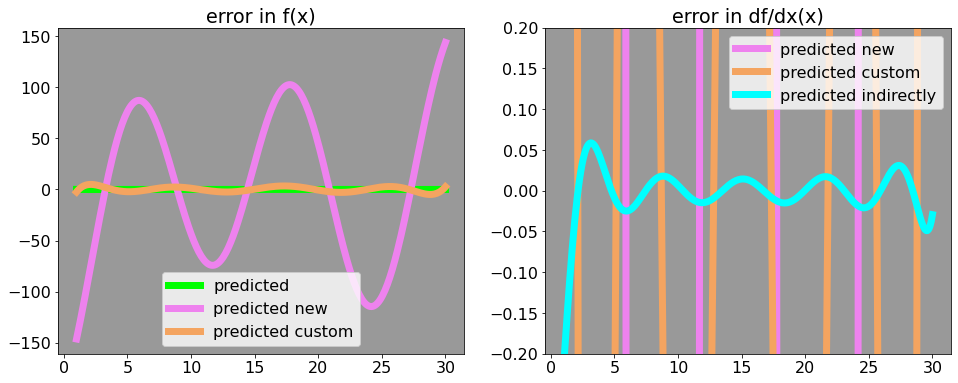

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,6))

ax1.plot(test_xs[ordering], predict_fs[ordering]-test_fs, "-", label="predicted",lw=7, color="lime")
ax1.plot(test_xs[ordering], predict_fs_new[ordering]-test_fs, "-", label="predicted new",lw=7, color="violet")
ax1.plot(test_xs[ordering], predict_fs_custom[ordering]-test_fs, "-", label="predicted custom",lw=7, color="sandybrown")
#ax1.plot(test_xs[ordering], test_fs[ordering], "o", label="test points", color="red", ms=7)
#ax1.plot(train_xs, train_fs, "o", label="train points", color="blue", ms=7)
ax1.set_facecolor([.6]*3)
ax1.set_title("error in f(x)")
ax1.legend()

#ax2.plot(test_xs[ordering], predict_dfdxs[ordering]-test_dfdxs, "-", label="predicted",lw=7, color="lime")
ax2.plot(test_xs[ordering], predict_dfdxs_new[ordering]-test_dfdxs, "-", label="predicted new",lw=7, color="violet")
ax2.plot(test_xs[ordering], predict_dfdxs_custom[ordering]-test_dfdxs, "-", label="predicted custom",lw=7, color="sandybrown")
ax2.plot(test_xs[ordering], predict_dfdxs_indirect[ordering]-test_dfdxs, "-", label="predicted indirectly", lw=7, color="cyan")
#ax2.plot(test_xs[ordering], test_dfdxs[ordering], "o", label="test points", color="red", ms=7)
#ax2.plot(train_xs, train_dfdxs, "o", label="train points", color="blue", ms=7)
ax2.set_title("error in df/dx(x)")
ax2.set_facecolor([.6]*3)
ax2.legend();#
ax2.set_ylim((-2e-1, 2e-1))

485.1965698120281


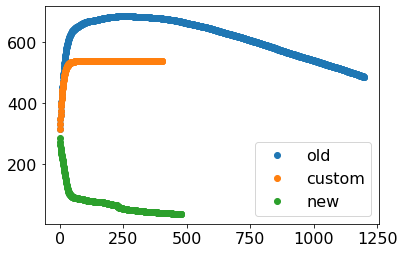

In [28]:
plt.plot(amps["old"], "o",label="old")
plt.plot(amps["custom"], "o",label="custom")
plt.plot(amps["new"], "o",label="new")
plt.legend()
print(amps["old"][-1])

6.058994861089305


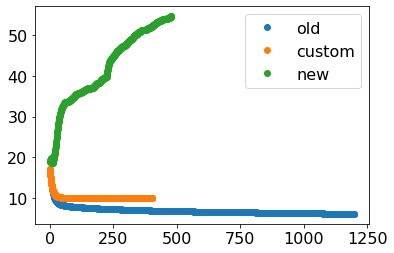

In [29]:
plt.plot(len_scales["old"], "o",label="old")
plt.plot(len_scales["custom"], "o",label="custom")
plt.plot(len_scales["new"], "o",label="new")
plt.legend()
print(len_scales["old"][-1])
#plt.yscale("log")

In [30]:
#@tf.function(autograph=False, experimental_compile=False)
def mse(y_predict, y_true):
    return tf.math.reduce_mean((y_predict - y_true)**2)

#@tf.function(autograph=False, experimental_compile=False)
def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
    mse1 = mse(y1_predict, y1_true)
    mse2 = mse(y2_predict, y2_true)
    return mse1 * weight1 + mse2 * weight2

def train_variable_epoch(epoch_n):
    print("Training with {} epochs".format(epoch_n))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05) #stochastic
    optimizer_new = tf.keras.optimizers.Adam(learning_rate=0.05)
    def gp_method_nll_f(index_points, f_observations):
        """Gaussian process negative-log-likelihood loss function."""
        f_gp = tfd.GaussianProcess(f_kernel, index_points=index_points, observation_noise_variance=f_obs_noise)
        f_nll = -f_gp.log_prob(f_observations)
        return f_nll
    
    # Next we will try to learn the analytically differentiable function AND its derivatives using a tensor flow gprm
    xs = np.linspace(1,30,60, dtype=np.float64)
    fs = np.array(f(xs))
    dfdxs = np.array(dfdx(xs))
    train_fract = 0.8; split_seed = 1; shuffle_seed = 2; batch_size=10; valid_fract=0.8; valid_split_seed=1
    train_xs, test_xs, train_fs, test_fs, train_dfdxs, test_dfdxs = train_test_split(xs, fs, dfdxs, random_state =split_seed, test_size=(1-train_fract))
    fs_var = train_fs.var(); dfdxs_var = train_dfdxs.var()

    # initialize kernels and model hyperparameters
    # ----------------------------------------------------------------------------------------
    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
    # f
    f_obs_noise = tfp.util.TransformedVariable(initial_value=.1, bijector=constrain_positive, dtype=np.float64, name="f_noise")#100#0#1e-3
    f_amplitude = tfp.util.TransformedVariable(initial_value=500, bijector=constrain_positive, dtype=np.float64, name="f_amplitude")
    f_length_scale = tfp.util.TransformedVariable(initial_value=6, bijector=constrain_positive, dtype=np.float64, name="f_length_scale")
    f_kernel = tfk.ExponentiatedQuadratic(amplitude=f_amplitude, length_scale=f_length_scale)
    # f_new
    f_obs_noise_new = tfp.util.TransformedVariable(initial_value=.1, bijector=constrain_positive, dtype=np.float64, name="f_noise_new")#100#0#1e-3
    f_amplitude_new = tfp.util.TransformedVariable(initial_value=500, bijector=constrain_positive, dtype=np.float64, name="f_amplitude_new")
    f_length_scale_new = tfp.util.TransformedVariable(initial_value=6, bijector=constrain_positive, dtype=np.float64, name="f_length_scale_new")
    f_kernel_new = tfk.ExponentiatedQuadratic(amplitude=f_amplitude_new, length_scale=f_length_scale_new)
    # 
    trainable_variables = [var.variables[0] for var in [f_amplitude, f_length_scale, f_obs_noise]]
    trainable_variables_new = [var.variables[0] for var in [f_amplitude_new, f_length_scale_new, f_obs_noise_new]]
    # ----------------------------------------------------------------------------------------
    observation_index_points= tf.constant(train_xs[:, None], dtype=np.float64)
    f_observations = tf.constant(train_fs, dtype=np.float64)
    dfdx_observations = tf.constant(train_dfdxs, dtype=np.float64)
    index_points = tf.constant(test_xs[:, None], dtype=np.float64)

    n_epochs=epoch_n


    n_iterations_new = int(len(train_fs)/ batch_size)
    for j in range(n_epochs):
        train_xs_j, valid_xs_j, train_fs_j, valid_fs_j, train_dfdxs_j, valid_dfdxs_j = train_test_split(train_xs, train_fs, train_dfdxs,
                                                                                                        random_state =valid_split_seed+j, test_size=(1-valid_fract))
        fs_var_j = train_fs_j.var(); dfdxs_var_j = train_dfdxs_j.var()
        observation_index_points_j = tf.constant(train_xs_j[:, None], dtype=np.float64)
        f_observations_j = tf.constant(train_fs_j, dtype=np.float64)
        dfdx_observations_j = tf.constant(train_dfdxs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_xs_j[:, None], dtype=np.float64)
        heldout_f_observations_j = tf.constant(valid_fs_j, dtype=np.float64)
        heldout_dfdx_observations_j = tf.constant(valid_dfdxs_j, dtype=np.float64)
        fs_var_j = train_fs_j.var(); dfdxs_var_j = train_dfdxs_j.var()
        batched_dataset_j = (
            tf.data.Dataset.from_tensor_slices(
            (observation_index_points_j, f_observations_j, dfdx_observations_j))
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size)
        )

        for i, (index_points_j_i, f_observations_j_i, dfdx_observations_j_i) in enumerate(islice(batched_dataset_j, n_iterations_new)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_dydx:
                    tape_dydx.watch(heldout_index_points_j)    
                    gprm_j_i = tfd.GaussianProcessRegressionModel(
                        kernel=f_kernel_new,
                        index_points=heldout_index_points_j,
                        observation_index_points=index_points_j_i,
                        observations=f_observations_j_i,
                        observation_noise_variance=f_obs_noise_new)
                    predict_fs_j_i = gprm_j_i.mean()
                error_j_i = mse(predict_fs_j_i, heldout_f_observations_j)#mse_2factor(predict_fs_j_i, heldout_f_observations_j, 1, tf.reshape(predict_dfdxs_j_i, [-1]), heldout_dfdx_observations_j, 0)#"""1/dfdxs_var_j""")#predict_fs_j_i[0]#np.sum((predict_fs_j_i.numpy(), heldout_f_observations_j.numpy(), 1/fs_var_j, predict_dfdxs_j_i.numpy().flatten(), heldout_dfdx_observations_j.numpy(), 1/dfdxs_var_j)).sum()#

                error_j_i = tf.constant(error_j_i, dtype=np.float64)
                
            grads = tape.gradient(error_j_i, trainable_variables_new)
            optimizer_new.apply_gradients(zip(grads, trainable_variables_new))


            with tf.GradientTape() as tape:
                f_nll = gp_method_nll_f(index_points_j_i, f_observations_j_i)
                f_nll = tf.constant(f_nll, dtype=np.float64)
            grads = tape.gradient(f_nll, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))


    # delete after debugging 
    test_xs =np.linspace(-20,50,600, dtype=np.float64)#xs
    test_fs = f(test_xs)
    index_points = tf.constant(test_xs[:, None], dtype=np.float64)
    # 



    f_gprm_new = tfd.GaussianProcessRegressionModel(
        kernel=f_kernel_new,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=f_observations,
        observation_noise_variance=f_obs_noise_new
    )

    predict_fs_new = f_gprm_new.mean()

    predict_fs_new = predict_fs_new.numpy()
    #---------------------------------------------


    f_gprm = tfd.GaussianProcessRegressionModel(kernel=f_kernel,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=f_observations,
        observation_noise_variance=f_obs_noise)

    predict_fs = f_gprm.mean()





    predict_fs = predict_fs.numpy()
    ordering = np.argsort(test_xs)

    line_nll_1.set_data(test_xs[ordering], predict_fs[ordering])
    line_mse_1.set_data(test_xs[ordering], predict_fs_new[ordering])
    line_true_1.set_data(test_xs, test_fs)
    line_train_1.set_data(train_xs, train_fs)
    ax1.set_title("predicting f(x) with {} epochs".format(epoch_n))

    line_nll_2.set_data(test_xs[ordering], predict_fs[ordering]-test_fs)
    line_mse_2.set_data(test_xs[ordering], predict_fs_new[ordering]-test_fs)
    line_train_2.set_data(train_xs, [0] * len(train_xs))
    ax2.set_title("error in predicting f(x) with {} epochs".format(epoch_n))
    return [line_nll_1, line_mse_1]


Training with 0 epochs
Training with 0 epochs
Training with 2 epochs
Training with 4 epochs
Training with 6 epochs
Training with 8 epochs
Training with 10 epochs
Training with 12 epochs
Training with 14 epochs
Training with 16 epochs
Training with 18 epochs


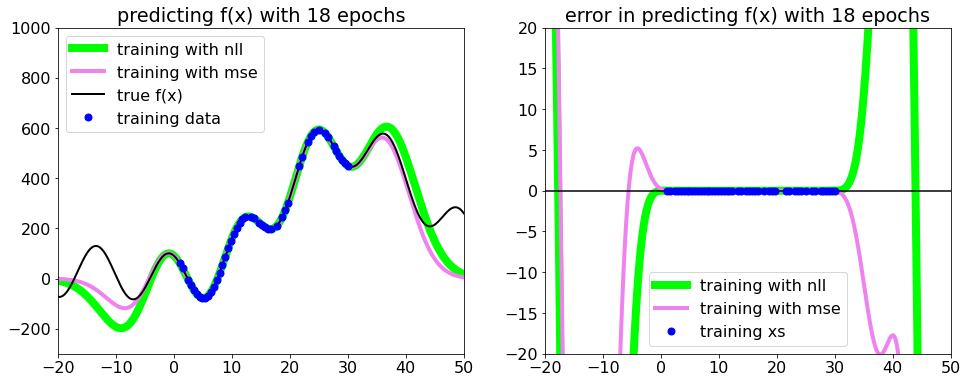

In [36]:


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,6))

#ax1.set_facecolor([.6]*3)
#ax2.set_facecolor([.6]*3)
line_nll_1, = ax1.plot([], [], '-', lw=8, color="lime", label="training with nll")
line_nll_2, = ax2.plot([], [], '-', lw=8, color="lime", label="training with nll")
line_mse_1, = ax1.plot([], [], '-', lw=4, color="violet", label="training with mse")
line_mse_2, = ax2.plot([], [], '-', lw=4, color="violet", label="training with mse")
line_true_1, = ax1.plot([], [], "-", lw=2, color="black", ms=5, label="true f(x)")
ax2.axhline(0, color="black")
line_train_1, = ax1.plot([], [], "o", label="training data", color="blue", ms=7)
line_train_2, = ax2.plot([], [], "o", label="training xs", color="blue", ms=7)
ax1.legend()
ax2.legend()
ax1.set_xlim((-20,50))
ax2.set_xlim((-20,50))
ax1.set_ylim((-300,1000))
ax2.set_ylim((-20,20))

# blit=True re-draws only the parts that have changed.
epochs = range(0,20,2)
anim = animation.FuncAnimation(fig, train_variable_epoch, frames=epochs, interval=150, blit=False)
HTML(anim.to_html5_video())

In [38]:
print(trainable_variables)
print([np.exp(t.numpy()) for t in trainable_variables[:3]])
print([np.exp(t.numpy()) for t in trainable_variables[3:]])
print([(t.name, np.exp(t.numpy())) for t in trainable_variables_new])
print(f_obs_noise_new)

[<tf.Variable 'f_amplitude:0' shape=() dtype=float64, numpy=6.1845541074077>, <tf.Variable 'f_length_scale:0' shape=() dtype=float64, numpy=1.8015439218174691>, <tf.Variable 'f_noise:0' shape=() dtype=float64, numpy=-1.6484139796851836>, <tf.Variable 'dfdx_amplitude:0' shape=() dtype=float64, numpy=4.873740050679619>, <tf.Variable 'dfdx_length_scale:0' shape=() dtype=float64, numpy=1.6363194864469948>, <tf.Variable 'dfdx_noise:0' shape=() dtype=float64, numpy=-1.537959057854824>]
[485.1965698120281, 6.058994861089305, 0.1923547453520091]
[130.80923633076543, 5.136230714606561, 0.2148190876522487]
[('f_amplitude_new:0', 36.95934250096586), ('f_length_scale_new:0', 54.671280252386104), ('f_noise_new:0', 0.8117055771729416)]
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.8117055771729416>


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299])

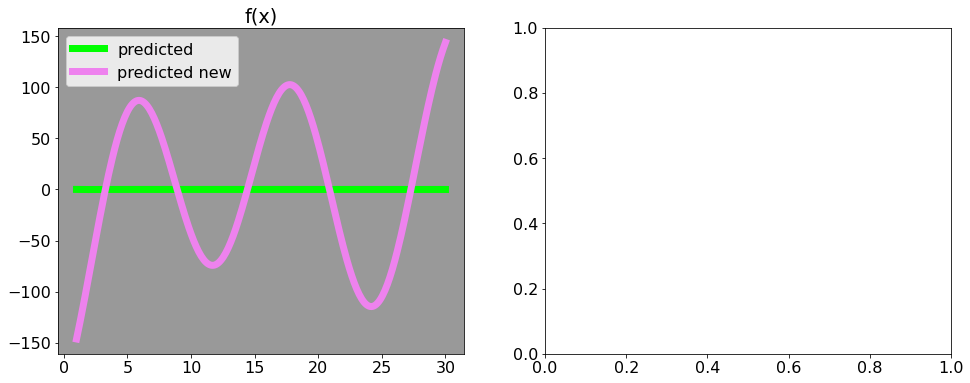

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,6))

ax1.plot(test_xs[ordering], predict_fs[ordering]-f(test_xs[ordering]), "-", label="predicted",lw=7, color="lime")
ax1.plot(test_xs[ordering], predict_fs_new[ordering]-f(test_xs[ordering]), "-", label="predicted new",lw=7, color="violet")
#ax1.plot(xs, fs, "-",label="true", lw=2, color="black", ms=5)
#ax1.plot(test_xs[ordering], test_fs[ordering], "o", label="test points", color="red", ms=7)
ax1.set_facecolor([.6]*3)
ax1.set_title("f(x)")
ax1.legend()


ax2.plot(test_xs[ordering], predict_dfdxs[ordering]-test_dfdxs[ordering], "-", label="predicted",lw=7, color="lime")
ax2.plot(test_xs[ordering], predict_dfdxs_new[ordering]-test_dfdxs[ordering], "-", label="predicted new",lw=7, color="violet")
#ax2.plot(test_xs[ordering], predict_dfdxs_indirect[ordering], "-", label="predicted indirectly", lw=7, color="cyan")
#ax2.plot(xs, dfdxs, "-",label="true", lw=2, color="black", ms=5)
#ax2.plot(test_xs[ordering], test_dfdxs[ordering], "o", label="test points", color="red", ms=7)
ax2.set_title("df/dx(x)")
ax2.set_facecolor([.6]*3)
ax2.legend();#



# soaps -> energies + forces

In [40]:
def test_energy_function(dist):
    return 1000*(dist - 1.00 ) **2

def test_force_function(dist):
    return [0.,0.,-2000* (dist - 1.00)]

In [41]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well

my_element="H"
my_temp=300
my_n = 100
my_calc = "EMT"#molecules
my_md_seed = 1
rand.seed(my_md_seed)

#AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8,my_n)]
AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n-1, md_type = "VelocityVerlet", calc_type=my_calc)
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
DistanceList = np.array([Distance(*atoms.positions) for atoms in AtomsList])
#EnergyList= test_energy_function(DistanceList)
EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
#ForceList= np.array([test_force_function(dist) for dist in DistanceList])
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=[my_element], is_global=False, return_derivatives=True, nmax=1,lmax=1)
#SoapDerivativeList = SoapDerivativeList[:,0,:,:,:]; SoapList = SoapList[:,0,:] # Using global soap right now so we can remove the local descriptor index
SoapList = SoapList[:,0,:] 
#SoapList = SoapList.reshape(len(SoapList),-1)

In [42]:
SoapDerivativeList[0]

array([[[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.53334999]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [-11.99982983,   0.17444568]]],


       [[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [ 11.99982983,  -0.17444568]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,  -0.53334999]]]])

In [43]:
SoapDerivativeList[0]

array([[[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.53334999]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [-11.99982983,   0.17444568]]],


       [[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [ 11.99982983,  -0.17444568]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,  -0.53334999]]]])

In [44]:
if False:
    SoapList = SoapList.reshape(-1,SoapList.shape[-1])
    SoapDerivativeList = SoapDerivativeList.reshape(-1, SoapDerivativeList.shape[2], SoapDerivativeList.shape[3], SoapDerivativeList.shape[4] )
    EnergyList = EnergyList.repeat(len(AtomsList[0]))/len(AtomsList[0])
    ForceList = ForceList.reshape(-1,ForceList.shape[-1])
    PosList = PosList.reshape(-1, PosList.shape[-1])
    DistanceList = DistanceList.repeat(len(AtomsList[0]))

In [45]:
if False:

    EnergyList = EnergyList[None,:].repeat(2, axis=0)#EnergyList.repeat(len(AtomsList[0])).reshape(-1, len(AtomsList[0]))/len(AtomsList[0])

In [46]:
collapsable = True

In [47]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.75
valid_fract = 0.75

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, DistanceList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_dist, test_dist, train_indices, test_indices = split_data

# scaling
if collapsable:
    # Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
    # both descriptors and their derivatives on training and test sets.
    # # pass with_mean=False to avoid breaking sparsity structure of data
    # soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
    # train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
    # train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
    # test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

    # # Should I also rescale energies and/or forces?
    # # For now I will
    # ens_scaler = StandardScaler().fit(train_ens)
    # train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
    # train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
    # test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

    ens_scaler = StandardScaler().fit(train_ens[:,None])
    train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
    train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
    test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.05
n_epochs = 5; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
if collapsable:
    noise_init = 1e-5; amp_init = 0.1; len_init = .5
    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
    # nll (old approach)
    obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
    amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
    len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
    kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
    trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
    # mostly mse, my custom approach
    # allows for forces to be considered during training
    obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
    amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
    len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
    kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=SoapList.shape[1])
    trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
if collapsable:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
        print("index_points.shape = ", index_points.shape)
        print("observations.shape = ", observations.shape)
        return -gp.log_prob(observations)

    # Define mini-batch data iterator
    batches_nll = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    #

    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    for j in range(n_epochs):
        if not j % 10:
            print("Old learning, epoch {}".format(j))

        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        print(index_points.shape)
        print(observation_index_points.shape)
        print(ens_observations.shape)
        predict_ens_nll = gprm_nll.mean()

    predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
    #print(predict_d_ens_nll[:1])
    #predict_d_ens_nll = predict_d_ens_nll[:,0,:]
    #print(predict_d_ens_nll[:1])

    print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
    print("test_d_sps.shape = ", test_d_sps.shape )
    print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
    print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
    predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
    print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

    # predict_d_ens_nll.shape = (75, 2, 18)
    # test_d_sps.shape =  (75, 2, 2, 3, 18)
#     print("test_d_sps", test_d_sps)
#     print("predict_d_ens_nll", predict_d_ens_nll)
#     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 3
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap
# -------------------------------------------------------------------

# probably don't need this anymore. From older code
if False:
    # predict_fs_custom = predict_fs_custom.numpy()
    # predict_dfdxs_custom = predict_dfdxs_custom.numpy().flatten()
    #-----------------------------------------------------------------




    # predict_fs = predict_fs.numpy()
    # predict_dfdxs = predict_dfdxs.numpy()
    # predict_dfdxs_indirect = predict_dfdxs_indirect.numpy().flatten()
    # ordering = np.argsort(test_xs)

    # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,6))

    # ax1.plot(test_xs[ordering], predict_fs[ordering], "-", label="predicted",lw=7, color="lime")
    # ax1.plot(xs, fs, "-",label="true", lw=2, color="black", ms=5)
    # ax1.plot(test_xs[ordering], test_fs[ordering], "o", label="test points", color="red", ms=7)
    # ax1.set_facecolor([.6]*3)
    # ax1.set_title("f(x)")
    # ax1.legend()

    # ax2.plot(test_xs[ordering], predict_dfdxs[ordering], "-", label="predicted",lw=7, color="lime")
    # ax2.plot(test_xs[ordering], predict_dfdxs_indirect[ordering], "-", label="predicted indirectly", lw=7, color="cyan")
    # ax2.plot(xs, dfdxs, "-",label="true", lw=2, color="black", ms=5)
    # ax2.plot(test_xs[ordering], test_dfdxs[ordering], "o", label="test points", color="red", ms=7)
    # ax2.set_title("df/dx(x)")
    # ax2.set_facecolor([.6]*3)
    # ax2.legend();#
    a=1

Old learning, epoch 0
index_points.shape =  (3, 2)
observations.shape =  (3,)
(25, 2)
(75, 2)
(75,)
predict_d_ens_nll.shape = (25, 2)
test_d_sps.shape =  (25, 2, 2, 3, 2)

test_d_sps[0][:,:,0] = 
 [[[  0.           0.45329481]
  [-10.23437622   0.1550579 ]]

 [[ 10.23437622  -0.1550579 ]
  [  0.          -0.45329481]]]

predict_d_ens_nll[0] = 
 tf.Tensor([ 6.90978515 -0.10572173], shape=(2,), dtype=float64)

predict_frcs_nll[0][:,0] = 
 [-70.68581066  70.68581066]


In [48]:
A = [[[ 0. ,        -0.06000157], [ 1.3495708,  -0.01954856]], [[-1.3495708 ,  0.01954856], [ 0.     ,     0.06000157]]]
B = [[-0.61960857,  0.00835418], [-0.61960857,  0.00835418]]
-1*np.einsum('mjl,ml->j', A, B)

array([-0.83586768,  0.83586768])

In [49]:
predict_frcs_nll.shape

(25, 2, 3)

In [50]:
test_frcs.shape

(25, 2, 3)

In [53]:
if plot_custom and plot_nll:
    for i in range(3):
        print(trainable_variables_nll[i].name, "    ", tf.math.exp(trainable_variables_nll[i]))
        print(trainable_variables_custom[i].name, "    ", tf.math.exp(trainable_variables_custom[i]))
        print()

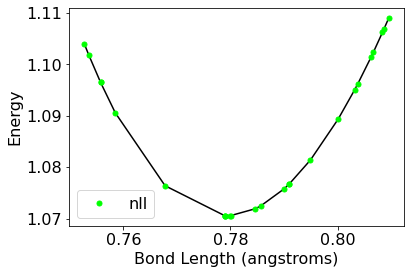

In [52]:
# Plotting energy vs bond length
plot_custom = False; plot_nll = True
distance_ordering = np.argsort(test_dist)
dists = test_dist[distance_ordering]
rescaled_test_ens = ens_scaler.inverse_transform(test_ens[distance_ordering], copy=True)
plt.plot(dists, rescaled_test_ens, c='k')
if plot_custom:
    rescaled_predict_ens_custom = ens_scaler.inverse_transform(predict_ens_custom.numpy()[distance_ordering], copy=True)
    plt.plot(dists, rescaled_predict_ens_custom, "o", label="custom", c="violet", ms=10)
if plot_nll:
    rescaled_predict_ens_nll =  ens_scaler.inverse_transform(predict_ens_nll.numpy()[distance_ordering], copy=True)
    plt.plot(dists, rescaled_predict_ens_nll, "o", label="nll", c="lime", ms=5)
plt.xlabel("Bond Length (angstroms)")
plt.ylabel("Energy")
plt.legend()

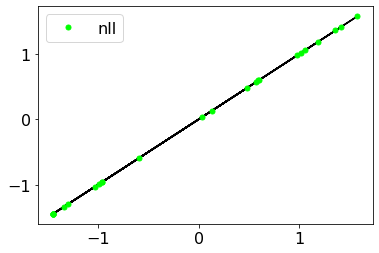

In [54]:
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

F = -dE/dx = dE/ds ds/dx = dE'/ds' ds'/dx

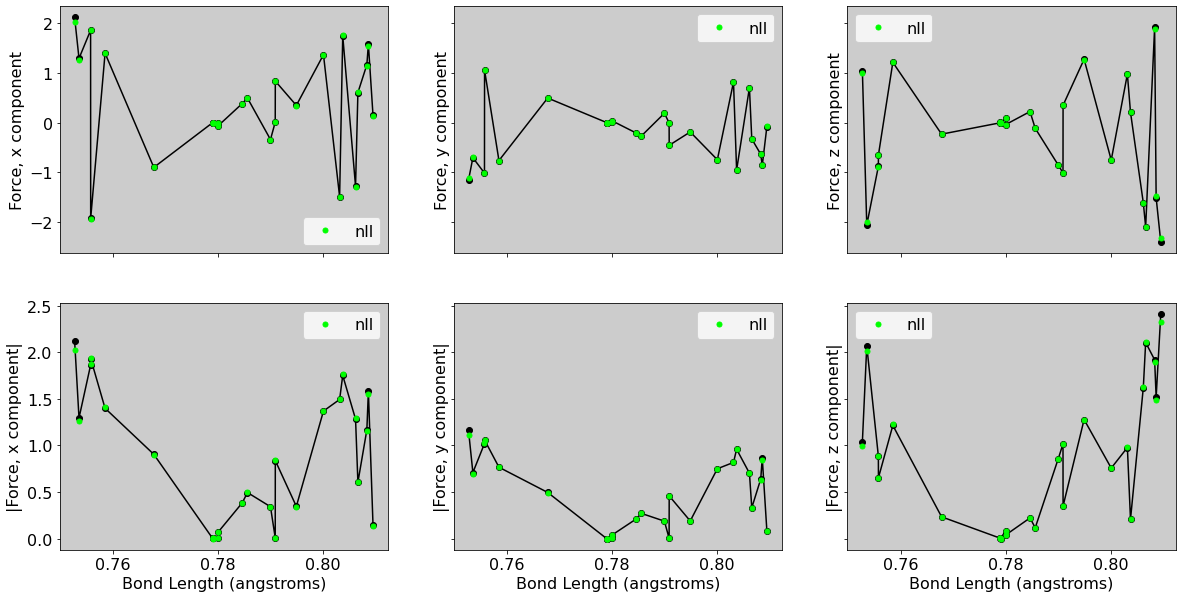

In [55]:
# Plotting force vs bond length
rescaled_test_frcs = test_frcs[distance_ordering] * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom[distance_ordering] * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll[distance_ordering] * ens_scaler.scale_

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10), sharex='all', sharey='row')
axs = axs.flatten()

components = ["x", "y", "z"]

for i in range(3):
    axs[i].plot(dists, rescaled_test_frcs[:,0,i], "o-", c='k')
    axs[i+3].plot(dists, abs(rescaled_test_frcs[:,0,i]), "o-",  c='k') 
    
    if plot_custom:
        axs[i].plot(dists, rescaled_predict_frcs_custom[:,0,i], "o", label="custom", c="violet",ms=10)
        axs[i+3].plot(dists, abs(rescaled_predict_frcs_custom[:,0,i]), "o", label="custom", c="violet",ms=10)
        
    if plot_nll:
        axs[i].plot(dists, rescaled_predict_frcs_nll[:,0,i], "o", label="nll", c="lime", ms=5)
        axs[i+3].plot(dists, abs(rescaled_predict_frcs_nll[:,0,i]), "o", label="nll", c="lime", ms=5)

    axs[i].set_facecolor([.8]*3)
    axs[i].legend()
    axs[i].set_ylabel("Force, {} component".format(components[i]))
    
    axs[i+3].set_facecolor([.8]*3)
    axs[i+3].legend()
    axs[i+3].set_ylabel("|Force, {} component|".format(components[i]))    
    axs[i+3].set_xlabel("Bond Length (angstroms)")

Least-squares regresion for Fx(x) produces the line line m x+b with m = 0.99413 and b = -0.00458 which has r2 = 0.99981 
Least-squares regresion for Fy(y) produces the line line m y+b with m = 0.99413 and b = 0.00251 which has r2 = 0.99981 
Least-squares regresion for Fz(z) produces the line line m z+b with m = 0.98695 and b = -0.00017 which has r2 = 0.99983 


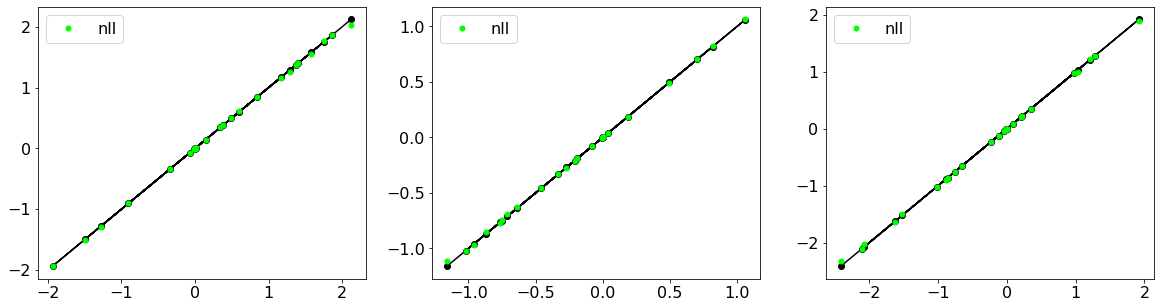

In [56]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

for i in range(3):
    axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_test_frcs[:,0,i], "o-", c="k")
    if plot_custom:
        axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_custom[:,0,i], "o", label="custom", c="violet", ms=10)
    if plot_nll:
        axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i], "o", label="nll", c="lime", ms=5)
        try:
            m, b = np.polyfit(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i], 1)
            r2 = np.corrcoef(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i])[0,1]
            print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
        except:
            pass        
    axs[i].legend()

In [57]:
noise_init = 1e-5; amp_init = 1; len_init = 3
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)

In [58]:
def loss_nll(index_points, observations):

    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

def gprm(obs_index_points, observations, index_points):
    print("batch_shape = ", kernel_nll.batch_shape)
    print("feature dimensions = ", kernel_nll.feature_ndims)
    print("obs_index_points.shape = ", obs_index_points.shape)    
    print("observations.shape = ", observations.shape)
    print("index_points.shape = ", index_points.shape)
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=obs_index_points,
        observations=observations,
        observation_noise_variance=obs_noise_nll)
    return gprm_nll.mean()

test_xs = tf.constant(rand.random(( 5,  2, 18)), dtype=np.float64)
xs = tf.constant(rand.random((3, 2, 18)), dtype=np.float64)
ys = rand.random(3)
#ys[0] = [300 for y in ys[0]]
ys = tf.constant(ys, dtype=np.float64)
PrintNoScientificNotation("predicitons = ", gprm(xs, ys,test_xs))
# This is not what we want
# The first (batch) dimension is only used to predict corresponding outputs

batch_shape =  ()
feature dimensions =  2
obs_index_points.shape =  (3, 2, 18)
observations.shape =  (3,)
index_points.shape =  (5, 2, 18)
predicitons =  tf.Tensor([0.38338199 0.58308328 0.43920567 0.54515858 0.59879727], shape=(5,), dtype=float64)


# ---------------------------------------------------------------------------------------
# Saving the model
# ---------------------------------------------------------------------------------------

In [59]:
# generate new split data for saving a model

# first generate the input data, including a new structural database
element = "N"; n = 100; temp = 300; is_global = True
AtomsList = generate_md_traj(element=element, verbose=False, nsteps = n-1, temperature=temp, from_diatomic=True)
EnergyList = np.array([atom.get_total_energy() for atom in AtomsList], dtype=np.float64)
SoapList = get_dscribe_descriptors(AtomsList, species=[element], nmax=5, lmax=5, is_global=is_global)

# then split it up
split_seed = 1; my_train_f = 0.75
TrainSoapList, TestSoapList, TrainEnergyList, TestEnergyList = train_test_split(SoapList, EnergyList, random_state=split_seed, test_size=(1-my_train_f))

In [60]:
# Create model object that can be saved
test_xs = tf.constant(TestSoapList, dtype=np.float64)
        
xs= tf.constant(TrainSoapList, dtype=np.float64)
ys = tf.constant(RegularizeData(TrainEnergyList), dtype=np.float64)
        #index_points = np.mean(test_sps, axis=1,dtype=np.float64)[..., np.newaxis]

observation_noise_variance = 1e-10

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# Smooth kernel hyperparameters
smooth_amplitude = tfp.util.TransformedVariable(
    initial_value=.1, bijector=constrain_positive, dtype=np.float64,
    name='MyTFGPRM')
smooth_length_scale = tfp.util.TransformedVariable(
    initial_value=.1, bijector=constrain_positive, dtype=np.float64,
    name='MyTFGPRM')
# Smooth kernel
smooth_kernel = tfk.ExponentiatedQuadratic(
    amplitude=smooth_amplitude, 
    length_scale=smooth_length_scale, name = "MyTFGPRM")

regression_model = tfd.GaussianProcessRegressionModel(kernel=smooth_kernel,
    index_points=test_xs,
    observation_index_points=xs,
    observations=ys,
    observation_noise_variance=observation_noise_variance,
    name = "MyTFGPRM")


class CustomModule3(tfd.GaussianProcessRegressionModel):

  def __init__(self, kernel,  test_xs, xs, ys,observation_noise_variance):
    super(CustomModule3, self).__init__(kernel, test_xs, xs, ys,observation_noise_variance)
    #self.v = tf.Variable(1., dtype=np.float64)
    #self.regression_model = tfd.GaussianProcessRegressionModel(kernel=kernel,
    #index_points=test_xs,
    #observation_index_points=xs,
    #observations=ys,
    #observation_noise_variance=observation_noise_variance)#,    name = name)#regression_model

    
  @tf.function()
  def mean_compiled(self):
    return self.mean()

module3 = CustomModule3(smooth_kernel, test_xs, xs, ys,observation_noise_variance)#, name = "MyTFGPRM")

In [61]:
module3.mean_compiled()

<tf.Tensor: shape=(25,), dtype=float64, numpy=
array([ 1.98496547e-01,  1.98930225e-01,  8.35745695e-01,  5.02753267e-02,
        3.61120349e-01,  2.80422831e-01,  9.07292500e-01, -4.54307370e-04,
        2.55507971e-03,  5.65096955e-01,  5.80692424e-01,  3.30463220e-01,
        6.16766842e-02,  3.97560595e-01,  6.34576306e-01,  6.51728949e-01,
        4.33770984e-01,  2.65161901e-01,  6.51401636e-01,  7.42089837e-01,
        7.85072634e-02,  7.10664178e-01,  7.14329497e-02,  9.78072228e-01,
        7.41672775e-01])>

In [62]:

module3_no_signatures_path = "Documents/Python/saved_ml_models/module_success"
my_x = 3#tf.constant(0., dtype=np.float64)
print('Saving model2...')
tf.saved_model.save(module3, module3_no_signatures_path)


Saving model2...
Instructions for updating:
the `jitter` property of `tfd.GaussianProcess` is deprecated; use the `marginal_fn` property instead.


Instructions for updating:
the `jitter` property of `tfd.GaussianProcess` is deprecated; use the `marginal_fn` property instead.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: Documents/Python/saved_ml_models/module_success/assets


INFO:tensorflow:Assets written to: Documents/Python/saved_ml_models/module_success/assets


In [63]:
tfrm_loaded = tf.saved_model.load( module3_no_signatures_path)
tfrm_loaded.mean_compiled()

<tf.Tensor: shape=(25,), dtype=float64, numpy=
array([ 1.98496547e-01,  1.98930225e-01,  8.35745695e-01,  5.02753267e-02,
        3.61120349e-01,  2.80422831e-01,  9.07292500e-01, -4.54307370e-04,
        2.55507971e-03,  5.65096955e-01,  5.80692424e-01,  3.30463220e-01,
        6.16766842e-02,  3.97560595e-01,  6.34576306e-01,  6.51728949e-01,
        4.33770984e-01,  2.65161901e-01,  6.51401636e-01,  7.42089837e-01,
        7.85072634e-02,  7.10664178e-01,  7.14329497e-02,  9.78072228e-01,
        7.41672775e-01])>

# ---------------------------------------------------------------------------------------
# Tensorflow Training
# ---------------------------------------------------------------------------------------

Here I :  
 -compare prediction accuracy between tensorflow and sklearn  
 -compare settings in tensorflow training to optimize accuracy and speed

In [64]:
split_seed = 2; train_f = 0.8
model_types = ["GP_sklearn", "GP_Tensorflow"]
fs_models = {}

xs = np.linspace(1,30, 600, dtype=np.float64)
fs = np.array(f(xs))
for model_type in model_types:
    print("Learning fs from xs using {} model".format(model_type))
    [Model, *split_data] = LearnEnergyFromSoap(xs[:, None], fs, training_fraction=train_f, is_global=True, verbose=True, kernel_type="RBF", 
                                               model_type=model_type, split_seed=split_seed, gamma = 300, batch_size=6, learn_rate=.05, n_iterations=1000)
    fs_models[model_type] = [Model, split_data]


InvalidArgumentError: Incompatible shapes: [2,2,2] vs. [600] [Op:Mul]

In [65]:
my_model = fs_models["GP_Tensorflow"][0]
my_model.plot_learning()

KeyError: 'GP_Tensorflow'

Text(0, 0.5, 'Absolute Error (|Predicted f(x) - f(x)|)')

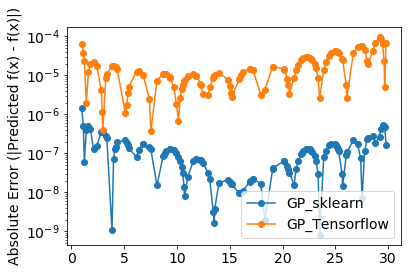

In [130]:
for model_type in model_types:
    test_xs, test_fs, train_xs, train_fs = fs_models[model_type][1]
    ordering = np.argsort(test_xs.flatten())
    model = fs_models[model_type][0]
    predict_fs = np.array(model.predict(test_xs))
    plt.plot(test_xs.flatten()[ordering], abs(predict_fs[ordering] - test_fs[ordering]), "o-", label=model_type)
plt.yscale("log")
plt.legend()
plt.ylabel("Absolute Error (|Predicted f(x) - f(x)|)")

In [208]:
[model.constrain_positive(var).numpy() for var in my_model.trainable_variables]

[0.48828885393666643, 5.871034223148776, 3.1206399616066976e-10]

Learning fs from xs using GP_Tensorflow model (param = 0.6)
Learning fs from xs using GP_Tensorflow model (param = 0.7)
Learning fs from xs using GP_Tensorflow model (param = 0.8)
Learning fs from xs using GP_Tensorflow model (param = 0.9)


Text(0, 0.5, 'Error (Predicted f(x) - f(x))')

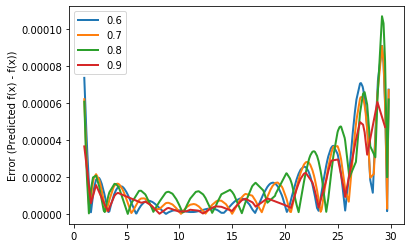

In [19]:
split_seed = 1; train_f = 0.8
param_vals = [.6, .7, .8, .9]
if 'fs_models_varying_params' not in locals():
    fs_models_varying_params = {}

for val in param_vals:
    xs = np.linspace(1,30, 600, dtype=np.float64)
    fs = np.array(f(xs))
    print("Learning fs from xs using GP_Tensorflow model (param = {})".format(val))
    [Model, *split_data] = LearnEnergyFromSoap(xs[:, None], fs, training_fraction=val, is_global=True, verbose=False, kernel_type="RBF", 
                                               model_type="GP_Tensorflow", split_seed=split_seed, gamma = 300, batch_size=6, learn_rate=.05, n_iterations=400)
    fs_models_varying_params[val] = [Model, split_data]
    test_xs, test_fs, train_xs, train_fs = fs_models_varying_params[val][1]
    ordering = np.argsort(test_xs.flatten())
    predict_fs = fs_models_varying_params[val][0].predict(test_xs).numpy()
    plt.plot(test_xs.flatten()[ordering], np.abs(predict_fs[ordering] - test_fs[ordering]), "-", label=val, lw=2)
plt.legend()
#plt.title("Varying batch size affects error for batch size < 6")
plt.ylabel("Error (Predicted f(x) - f(x))")
#plt.xlim(25,31)
#plt.ylim(.00035,.0006)
    

In [79]:
print(len(xs))

2900


Learning fs from xs using GP_sklearn model (param = 0.6)


/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.02826731]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


Learning fs from xs using GP_sklearn model (param = 0.7)
Learning fs from xs using GP_sklearn model (param = 0.8)
Learning fs from xs using GP_sklearn model (param = 0.9)


Text(0, 0.5, 'Error (Predicted f(x) - f(x))')

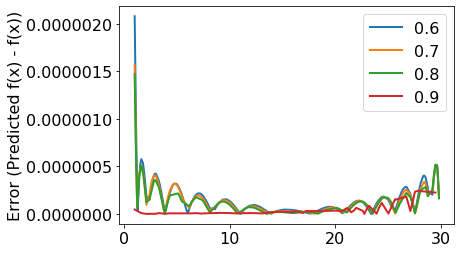

In [158]:
split_seed = 1; train_f = 0.8
param_vals = [.6, .7, .8, .9]#,4,6,12]#[29, 290, 2900, 29000]
if 'fs_models_varying_params' not in locals():
    fs_models_varying_params = {}

for val in param_vals:
    print("Learning fs from xs using GP_sklearn model (param = {})".format(val))
    xs = np.linspace(1,30, 600, dtype=np.float64)
    fs = np.array(f(xs))
    [Model, *split_data] = LearnEnergyFromSoap(xs[:, None], fs, training_fraction=val, is_global=True, verbose=False, kernel_type="RBF", 
                                               model_type="GP_sklearn", split_seed=split_seed, gamma = 300, batch_size=6, learn_rate=.05, n_iterations=400)
    fs_models_varying_params[val] = [Model, split_data]
    test_xs, test_fs, train_xs, train_fs = fs_models_varying_params[val][1]
    ordering = np.argsort(test_xs.flatten())
    predict_fs = fs_models_varying_params[val][0].predict(test_xs)
    plt.plot(test_xs.flatten()[ordering], np.abs(predict_fs[ordering] - test_fs[ordering]), "-", label=val, lw=2)
plt.legend()
#plt.title("Varying batch size affects error for batch size < 6")
plt.ylabel("Error (Predicted f(x) - f(x))")
#plt.xlim(25,31)
#plt.ylim(.00035,.0006)
    

In [122]:
# This cell is an adaptation of the above cell for the anlytical function
# The purpose of this cell is collect error data for later plotting and analysis. The data is stored in Plottable_Model_Errors.
# Many variable can be adjusted, including which model types are trained and which error types are collected

train_f = 0.8; learn_seed = 1; split_seed=1

unique_ns = [300, 1000,3000,6000]#,200]#[100,200,300]
repeats = 5
ns_list = np.repeat(unique_ns, repeats)

error_types = ["absolute", "rms", "max"]
model_types = ["GP_sklearn", "GP_Tensorflow"]#, "Polynomial"]
Plottable_Model_Errors = {error_type: {model_type: [] for model_type in model_types} for error_type in error_types}

i = red_numbers(start=1) # generate red numbers starting at 1
c = "During each trial, this cell will first ({}) create new input data xs and fs=f(xs),\n".format(i.tr()) + \
    "then ({}) train a new regression model to learn fs from xs and finally ({}) collect several types of\n".format(i.tr(), i.tr()) + \
    "learning error which will be stored in Plottable_Model_Errors. To retrieve the error type A for model type B, use Plottable_Model_Errors[A][B].\n" + \
    "error types: {}\nmodel types: {}\n".format(error_types, model_types) + \
    "The number of structures, n, can vary between trials. There will be {} trials for each unique n-value, for a total of {} trials.\n".format(repeats, len(ns_list)) + \
    "unique ns: {}".format(unique_ns)
cell_announcement = c # I used two names here to allow the long strings to fit in the cell more easily
print(cell_announcement)
print("-"*80)

def print_update(append_string=""):
    print("starting ({}){}".format(i.tr(), append_string), end=" ... ")

for n_index in range(len(ns_list)):
    n = ns_list[n_index]
    i = red_numbers(start=1) # generate red numbers starting at 1
    print("Starting n={} trial".format(n), end=" ... ")
    print_update(); xs = np.linspace(1,30,n); fs = f(xs)
    loop_start_step = i.state
    for model_type in model_types:
        i = red_numbers(start=loop_start_step)
        print_update("-{}".format(model_type))
        Model, test_xs, test_fs, train_xs, train_fs = LearnEnergyFromSoap(xs[:,None], fs, training_fraction=train_f, is_global=True, verbose=False, 
                                                                          model_type=model_type, split_seed=split_seed, gamma = 300, kernel_type="RBF",
                                                                          batch_size=6, learn_rate=0.05, n_iterations=400)
        print_update("-{}".format(model_type))
        Errors = GetErrorFromModel(Model, test_xs, test_fs, error_types=error_types)
        for error_index in range(len(error_types)):
            Plottable_Model_Errors[error_types[error_index]][model_type].append(Errors[error_index]) 
    print("done with this trial ({:3.0%} done overall)".format( (n_index + 1)/len(ns_list)))
print("All done! No issues!")

During each trial, this cell will first (1) create new input data xs and fs=f(xs),
then (2) train a new regression model to learn fs from xs and finally (3) collect several types of
learning error which will be stored in Plottable_Model_Errors. To retrieve the error type A for model type B, use Plottable_Model_Errors[A][B].
error types: ['absolute', 'rms', 'max']
model types: ['GP_sklearn', 'GP_Tensorflow']
The number of structures, n, can vary between trials. There will be 5 trials for each unique n-value, for a total of 20 trials.
unique ns: [300, 1000, 3000, 6000]
--------------------------------------------------------------------------------
Starting n=300 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial ( 5% done overall)
Starting n=300 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_

/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03260266]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (55% done overall)
Starting n=3000 trial ... starting (1) ... starting (2)-GP_sklearn ... 

/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03260266]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (60% done overall)
Starting n=3000 trial ... starting (1) ... starting (2)-GP_sklearn ... 

/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03260266]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (65% done overall)
Starting n=3000 trial ... starting (1) ... starting (2)-GP_sklearn ... 

/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03260266]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (70% done overall)
Starting n=3000 trial ... starting (1) ... starting (2)-GP_sklearn ... 

/home/sstafford/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03260266]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (75% done overall)
Starting n=6000 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (80% done overall)
Starting n=6000 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (85% done overall)
Starting n=6000 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (90% done overall)
Starting n=6000 trial ... starting (1) ... starting (2)-GP_sklearn ... starting (3)-GP_sklearn ... starting (2)-GP_Tensorflow ... starting (3)-GP_Tensorflow ... done with this trial (95% done overall)
Starting n=6000 trial ... starting (1) ... starting (2)-GP_sklearn

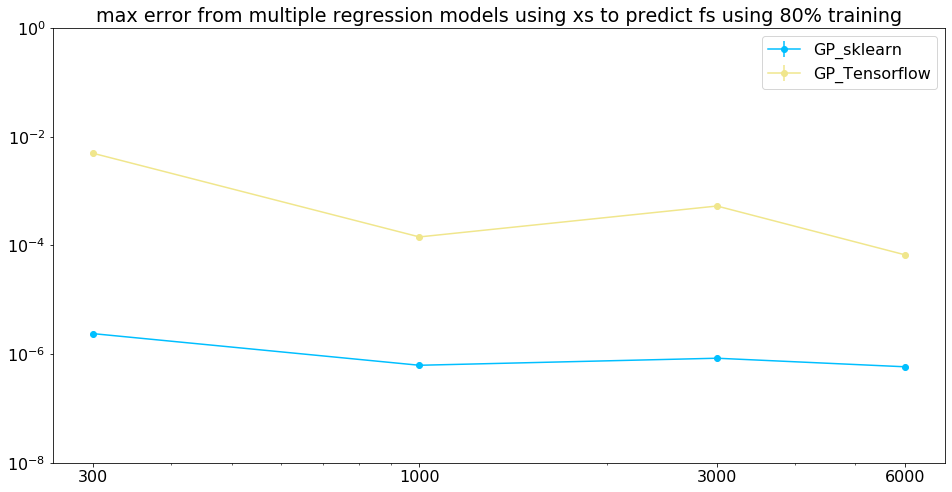

In [148]:
fig, ax = plt.subplots(figsize=(16,8))
model_type_colors = {"GP_Tensorflow":"khaki", "GP_sklearn":"deepskyblue", "Polynomial":"green"}
plotted_error_type = "max"
summary_stats = True
for model_type in model_types:
    if summary_stats:
        means = []
        std_errs = []
        for n in unique_ns:
            errors = np.array(Plottable_Model_Errors[plotted_error_type][model_type])
            errors_n = errors[np.where(ns_list == n)[0]]
            means.append(np.mean(errors_n))
            std_errs.append(np.std(errors_n)/np.sqrt(len(errors_n)))
        ax.errorbar(unique_ns, means, yerr=std_errs, label=model_type, fmt="-o", color = model_type_colors[model_type])
    else:
        ax.scatter(ns_list, Plottable_Model_Errors[plotted_error_type][model_type], color=model_type_colors[model_type], label=model_type, s=32)
title = u"{} error from multiple regression models using xs to predict fs using {:.0%} training".format(plotted_error_type, train_f)
matplotlib.rc('font', size=16)
ax.set_title(title)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(unique_ns)
ax.set_xticklabels(unique_ns)
ax.set_ylim(top=1, bottom=1e-8)
#ax.set_facecolor([.999]*3)
plt.show()

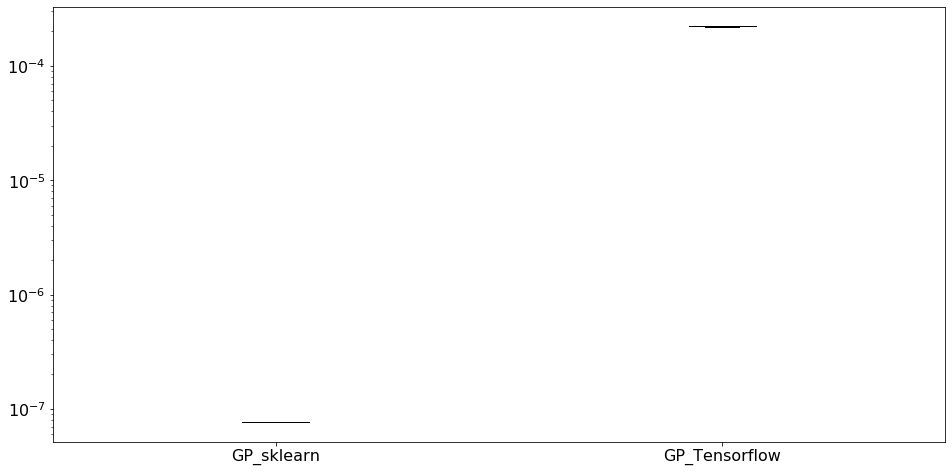

In [109]:
fig, ax = plt.subplots(figsize=(16,8))
model_type_colors = {"GP_Tensorflow":"khaki", "GP_sklearn":"deepskyblue", "Polynomial":"green"}
plotted_error_type = "absolute"

listed_errors = list(Plottable_Model_Errors[plotted_error_type].values())
boxplot = ax.boxplot(listed_errors, labels=model_types, patch_artist=True)
for i in range(len(model_types)):
    boxplot["boxes"][i].set_facecolor(model_type_colors[model_types[i]])
    boxplot["medians"][i].set_color("k")
plt.yscale("log")

In [47]:
# Check on loss (negative log likelihood) convergence for a pre-generated AtomsList
train_f = 0.8; 
learn_seed = 1; split_seed=1
batch_size=3; n_iterations=100; learn_rate=0.05 #skip learning entirely (learn rate and batch size have no meaning)
noise_initial = 1e-10#e-10
amp = 10; len_sc = 10

Model, *unused = LearnEnergyFromSoap(SoapList, EnergyList, is_global=True, model_type="GP_Tensorflow",
                                     training_fraction=train_f, 
                                     learn_seed = learn_seed, split_seed = split_seed,
                                     batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
                                     noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc)
print(Model.smooth_amplitude, Model.full_loss_history[-1])
amp = 2
Model, *unused = LearnEnergyFromSoap(SoapList, EnergyList, is_global=True, model_type="GP_Tensorflow",
                                     training_fraction=train_f, 
                                     learn_seed = learn_seed, split_seed = split_seed,
                                     batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
                                     noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc)
print(Model.smooth_amplitude, Model.full_loss_history[-1])
Model.smooth_amplitude.assign(10); Model.smooth_length_scale.assign(len_sc); Model.observation_noise_variance.assign(noise_initial)
Model.fit(batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate, shuffle_seed=learn_seed)
print(Model.smooth_amplitude, Model.full_loss_history[-1])

Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=1.211810946222495> (<__main__.red_numbers object at 0x7fd458afee10>, -1378.3009041267665)
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=4.303379014509076> (<__main__.red_numbers object at 0x7fd458afee10>, -1385.9209209207759)
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=1.211810946222495> (<__main__.red_numbers object at 0x7fd458afee10>, -1378.3009041267665)


In [39]:
print(Model.smooth_amplitude, Model.full_loss_history[-1])#.assign(11)
Model.smooth_amplitude.assign(11)
Model.fit(batch_size=3, n_iterations=1, learn_rate=0.05, shuffle_seed=1)
print(Model.smooth_amplitude, Model.full_loss_history[-1])

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.951229499125359> (<__main__.red_numbers object at 0x7fd458afee10>, -1365.5201579388097)
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=10.463524214802069> (<__main__.red_numbers object at 0x7fd458afee10>, -1343.6179461177878)


In [70]:
time_new_initial = time.time()
# Check on loss (negative log likelihood) convergence for a pre-generated AtomsList
train_f = 0.8; 
learn_seed = 1; split_seed=1
batch_size=3; n_iterations=0; learn_rate=0.05 #skip learning entirely (learn rate and batch size have no meaning)
noise_initial = 1e-10#e-10
#a1 = np.linspace(.1, 2, 5)
#a2 = np.linspace(2, 400, 20)
#amplitudes =np.array([a for a in a1] + [a for a in a2])
amplitudes = np.logspace(-1, 1, 50)
length_scales = np.linspace(4,10,50)#np.logspace(-.99, .99, 8)
loss = np.zeros((len(amplitudes), len(length_scales)))
xs = np.linspace(1,30,300, dtype=np.float64)
fs = np.array(f(xs))
xs = xs[:, None]
Model, *unused = LearnEnergyFromSoap(xs, fs, is_global=True, model_type="GP_Tensorflow",
                                     training_fraction=train_f, 
                                     learn_seed = learn_seed, split_seed = split_seed,
                                     batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate)
for i in range(len(amplitudes)):
    print("Collecting data for amplitude = {}. (Progress: {:.1%})".format(amplitudes[i], i/len(amplitudes)))
    amp = amplitudes[i]
    for j in range(len(length_scales)):
        #print("Collecting data for length scale  = {}.".format(length_scales[j] ))
        len_sc = length_scales[j]
#         Model, *unused = LearnEnergyFromSoap(xs, fs, is_global=True, model_type="GP_Tensorflow",
#                                                  training_fraction=train_f, 
#                                                  learn_seed = learn_seed, split_seed = split_seed,
#                                                  batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
#                                                  noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc)
        try:
            Model.smooth_amplitude.assign(amp)
            Model.smooth_length_scale.assign(len_sc)
            Model.observation_noise_variance.assign(noise_initial)
            Model.fit(batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate, shuffle_seed=learn_seed)

#             Model, *unused = LearnEnergyFromSoap(xs, fs, is_global=True, model_type="GP_Tensorflow",
#                                                  training_fraction=train_f, 
#                                                  learn_seed = learn_seed, split_seed = split_seed,
#                                                  batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
#                                                  noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc)
            loss[i,j]=Model.full_loss_history[-1][1]
        except:
            print("Ran into issue with amplitude = {:8.3f}, length_scale = {:8.3f}".format(amp, len_sc))
            loss[i,j]=np.nan
    #title ="Training progress for learnign with:\nbatch_size={}\nn_iterations={}\nlearning_rate={}".format(batch_size, n_iterations, learn_rate)
    #Model.plot_learning(title=title)
time_new_final= time.time()
time_span_new = time_new_final - time_new_initial
print("This cell took {} seconds".format(time_span_new))

Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
This cell took 61.69201421737671 seconds


Text(0, 0.5, 'Kernel length scale')

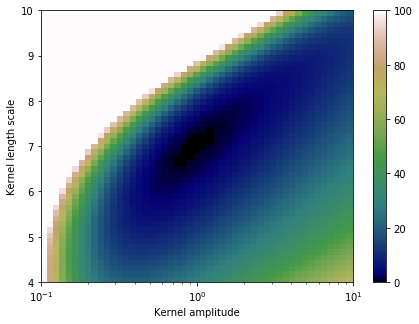

In [71]:

diff_between_smallest = np.abs(np.subtract(*loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]]))
max_allowed_diff = 100*max(diff_between_smallest,1)
if not diff_between_smallest:
    print("smallest is degenerate, this may cause issue")
smallest = np.min(loss)
loss_transformed = loss - smallest
loss_transformed = np.minimum(loss_transformed, max_allowed_diff).transpose()

#shift = -np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])
#loss_shifted = loss + shift
#loss_shifted = np.minimum(loss_shifted, 2*shift).transpose()
X,Y=np.meshgrid(amplitudes, length_scales)
fig, ax = plt.subplots(figsize=(7,5))
matplotlib.rc('image', cmap='gist_earth')
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='gray')
#cmap = "gist_earth"#'nipy_spectral'

log_color_scale = False# True
if log_color_scale:
    im = ax.pcolormesh(X,Y, loss_transformed, norm=LogNorm())
    plt.colorbar(im, orientation='vertical', format=LogFormatterMathtext())
else:
    im = ax.pcolormesh(X,Y, loss_transformed)
    plt.colorbar(im, orientation='vertical')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("Kernel amplitude")
ax.set_ylabel("Kernel length scale")

In [24]:
which_loss = loss_transformed#loss.transpose()
for i in range(1, len(which_loss)+1):
    print(" ".join(["{:8.0f}".format(y) for y in which_loss[-i]])+"\n")

     100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100       87       65       49       37       29       23       20

     100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100       76       56       42       32       25       20       17       15

     100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100       89       65       48       36       27       21       17       15       13       13

     100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100      100       77       5

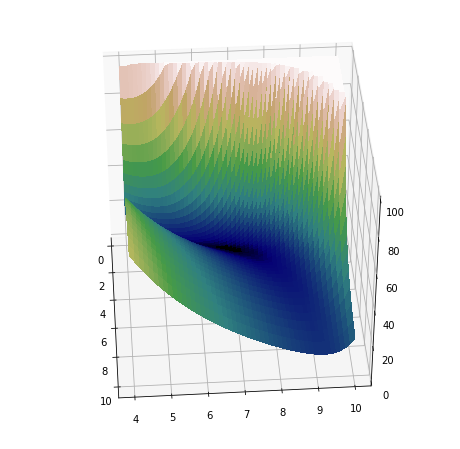

In [74]:
fig = plt.figure(figsize=(8,8))
ax3d = plt.subplot(111, projection='3d')
ax3d.view_init(elev=70)#, azim=0)
#ax3d.grid(False)
#ax3d.axis('off')
#X,Y=np.meshgrid(length_scales,amplitudes)
#shift = -np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])
#loss_shifted = loss + shift
#loss_shifted = np.minimum(loss_shifted, 2*shift)
Z = loss_transformed
lines_3d = []
surf = ax3d.plot_surface(X, Y, Z, cmap=cm.gist_earth, linewidth=0, antialiased=False)#, vmin=.5*shift, vmax=1.25*shift)
#ax3d.set_zlim(0, 1.25*shift)
def rotate_plot(j):
    ax3d.view_init(elev=40,azim=j)
    return [surf]


n_animated_frames = 100#n_md_steps
anim = animation.FuncAnimation(fig, rotate_plot, frames=range(0,360,4), interval=100, blit=True)
HTML(anim.to_html5_video())

In [43]:
# Check on loss (negative log likelihood) convergence for a pre-generated AtomsList
train_f = 0.8; 
learn_seed = 1; split_seed=1
batch_size=3; n_iterations=0; learn_rate=0.05 #skip learning entirely (learn rate and batch size have no meaning)
noise_initial = 1e-5#e-10
#a1 = np.linspace(.1, 2, 5)
#a2 = np.linspace(2, 400, 20)
#amplitudes =np.array([a for a in a1] + [a for a in a2])
amplitudes = np.linspace(200, 400, 30)
length_scales = np.linspace(.101,9,15)#np.logspace(-.99, .99, 8)
loss = np.zeros((len(amplitudes), len(length_scales)))
for i in range(len(amplitudes)):
    print("Progress: {:.1%}".format(i/len(amplitudes)))
    amp = amplitudes[i]
    for j in range(len(length_scales)):
        len_sc = length_scales[j]
        Model, *unused = LearnEnergyFromSoap(SoapList, EnergyList, is_global=True, model_type="GP_Tensorflow",
                                                 training_fraction=train_f, 
                                                 learn_seed = learn_seed, split_seed = split_seed,
                                                 batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
                                                 noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc, jitter=1e-3)
#         try:
#             Model, *unused = LearnEnergyFromSoap(SoapList, EnergyList, is_global=True, model_type="GP_Tensorflow",
#                                                  training_fraction=train_f, 
#                                                  learn_seed = learn_seed, split_seed = split_seed,
#                                                  batch_size=batch_size, n_iterations=n_iterations, learn_rate=learn_rate,
#                                                  noise_init = noise_initial, amplitude_init = amp, length_scale_init = len_sc)
#             loss[i,j]=Model.full_loss_history[-1][1]
#         except:
#             print("Ran into issue with amplitude = {}, length_scale = {}".format(amp, len_sc))
#             loss[i,j]=np.nan#1e10#"N/A"
#     #title ="Training progress for learnign with:\nbatch_size={}\nn_iterations={}\nlearning_rate={}".format(batch_size, n_iterations, learn_rate)
    #Model.plot_learning(title=title)

Progress: 0.0%
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Progress: 3.3%
Now tracin

InvalidArgumentError:  Cholesky decomposition was not successful. The input might not be valid.
	 [[node GaussianProcess_1/log_prob/GaussianProcess/get_marginal_distribution/Cholesky (defined at /home/sstafford/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:379) ]] [Op:__inference_get_loss_1522364]

Errors may have originated from an input operation.
Input Source operations connected to node GaussianProcess_1/log_prob/GaussianProcess/get_marginal_distribution/Cholesky:
 GaussianProcess_1/log_prob/GaussianProcess/get_marginal_distribution/add_diagonal_shift_1 (defined at /home/sstafford/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:47)

Function call stack:
get_loss


Text(0, 0.5, 'Kernel length scale')

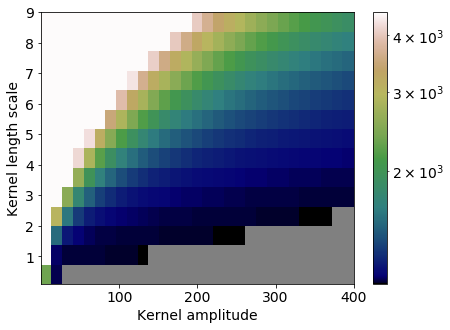

In [78]:


shift = -np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])
loss_shifted = loss + shift
loss_shifted = np.minimum(loss_shifted, 2*shift).transpose()
X,Y=np.meshgrid(amplitudes, length_scales)
fig, ax = plt.subplots(figsize=(7,5))
log_color_scale = True
matplotlib.rc('image', cmap='gist_earth')
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='gray')
#cmap = "gist_earth"#'nipy_spectral'
if log_color_scale:
    im = ax.pcolormesh(X,Y, loss_shifted, norm=LogNorm())
    plt.colorbar(im, orientation='vertical', format=LogFormatterMathtext())
else:
    im = ax.pcolormesh(X,Y, loss_shifted, cmap=cmap)
    plt.colorbar(im, orientation='vertical')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("Kernel amplitude")
ax.set_ylabel("Kernel length scale")

Text(0, 0.5, 'Kernel length scale')

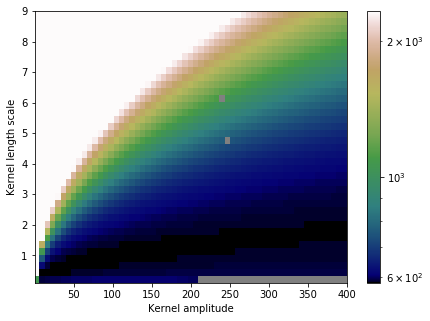

In [67]:



shift = -np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])
loss_shifted = loss + shift
loss_shifted = np.minimum(loss_shifted, 2*shift).transpose()
X,Y=np.meshgrid(amplitudes, length_scales)
fig, ax = plt.subplots(figsize=(7,5))
log_color_scale = True
matplotlib.rc('image', cmap='gist_earth')
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='gray')
#cmap = "gist_earth"#'nipy_spectral'
if log_color_scale:
    im = ax.pcolormesh(X,Y, loss_shifted, norm=LogNorm())
    plt.colorbar(im, orientation='vertical', format=LogFormatterMathtext())
else:
    im = ax.pcolormesh(X,Y, loss_shifted, cmap=cmap)
    plt.colorbar(im, orientation='vertical')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("Kernel amplitude")
ax.set_ylabel("Kernel length scale")

/home/sstafford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Z contains NaN values. This may result in rendering artifacts.


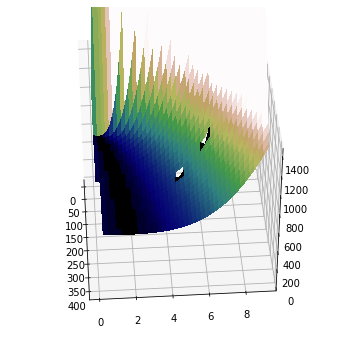

In [68]:

fig = plt.figure(figsize=(13,6))
ax3d = plt.subplot(121, projection='3d')
ax3d.view_init(elev=70)#, azim=0)
#ax3d.grid(False)
#ax3d.axis('off')
#X,Y=np.meshgrid(length_scales,amplitudes)
#shift = -np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])
#loss_shifted = loss + shift
#loss_shifted = np.minimum(loss_shifted, 2*shift)
Z = loss_shifted
lines_3d = []
surf = ax3d.plot_surface(X, Y, Z, cmap=cm.gist_earth, linewidth=0, antialiased=False, vmin=.5*shift, vmax=1.25*shift)
ax3d.set_zlim(0, 1.25*shift)
def rotate_plot(j):
    ax3d.view_init(elev=40,azim=j)
    return [surf]


n_animated_frames = 100#n_md_steps
anim = animation.FuncAnimation(fig, rotate_plot, frames=range(0,360,4), interval=100, blit=True)
HTML(anim.to_html5_video())

Now tracing TensorflowGaussianProcessRegressionModel.get_loss()
Now tracing TensorflowGaussianProcessRegressionModel.get_loss()


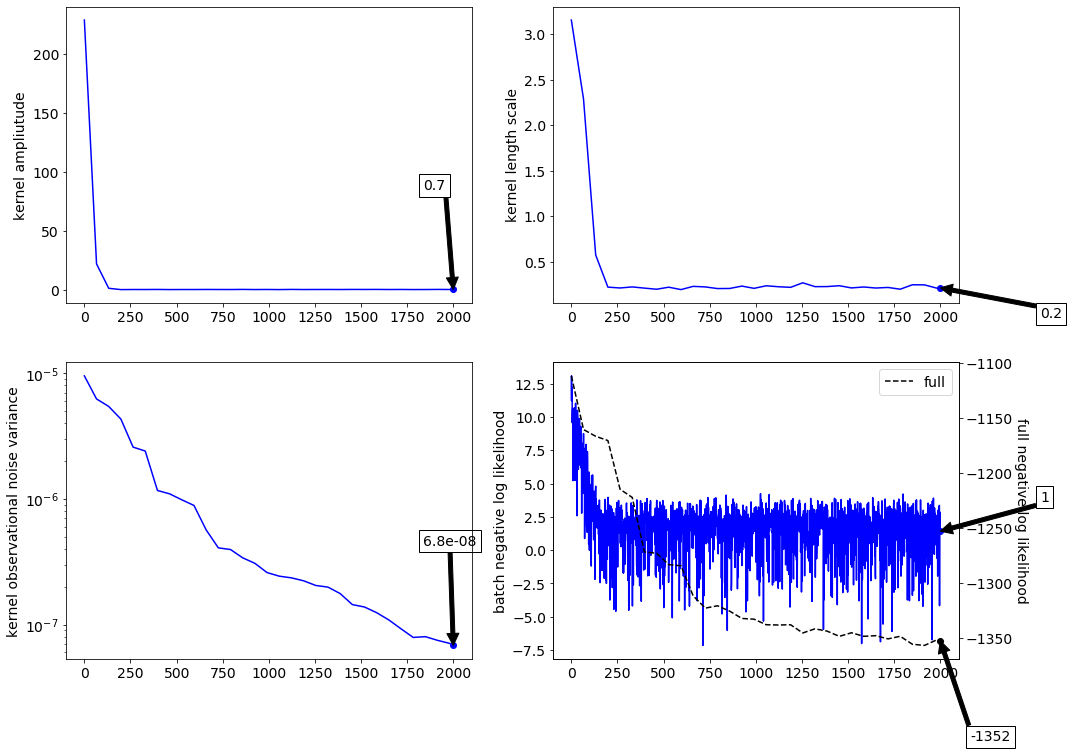

In [28]:
Model, *unused = LearnEnergyFromSoap(SoapList, EnergyList, is_global=True, model_type="GP_Tensorflow",
                                                 training_fraction=train_f, 
                                                 learn_seed = learn_seed, split_seed = split_seed,
                                                 batch_size=batch_size, n_iterations=2000, learn_rate=learn_rate,
                                                 noise_init = 1e-5, amplitude_init = 240, length_scale_init = 3)
Model.plot_learning()

In [179]:
np.sum(loss.flatten()[np.argpartition(loss.flatten(), 2)[:2]])

-2777.3215049892824

In [175]:
np.minimum(loss_shifted, 2000)

array([[1582.63750113, 1652.65229997, 2000.        , 2000.        ,
        2000.        , 2000.        , 2000.        , 2000.        ,
        2000.        , 2000.        ],
       [1492.94698993, 1496.69358717, 1731.38491754, 2000.        ,
        2000.        , 2000.        , 2000.        , 2000.        ,
        2000.        , 2000.        ],
       [1465.40586408, 1438.85590098, 1515.10572441, 2000.        ,
        2000.        , 2000.        , 2000.        , 2000.        ,
        2000.        , 2000.        ],
       [1461.70207399, 1420.49093039, 1433.68192062, 1710.41662911,
        2000.        , 2000.        , 2000.        , 2000.        ,
        2000.        , 2000.        ],
       [1467.32055583, 1417.36162788, 1405.66749057, 1499.55475768,
        2000.        , 2000.        , 2000.        , 2000.        ,
        2000.        , 2000.        ],
       [1476.75932746, 1420.16100288, 1397.68235734, 1423.49665423,
        1942.36100084, 2000.        , 2000.        , 2000

In [182]:
which_loss = loss_shifted
for i in range(len(which_loss)):
    print(" ".join(["{:8.1e}".format(y) for y in which_loss[-i]])+"\n")

 1.6e+03  1.7e+03  2.3e+03  7.1e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.4e+03  1.4e+03  1.5e+03  5.0e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.4e+03  1.4e+03  1.7e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.4e+03  1.5e+03  2.2e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.4e+03  1.6e+03  3.6e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.4e+03  1.9e+03  7.2e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.5e+03  2.5e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.4e+03  1.7e+03  3.7e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.4e+03  1.5e+03  2.3e+03  6.9e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03

 1.5e+03  1.5e+03  1.7e+03  3.7e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03  8.3e+03



In [165]:
which_loss = loss
for i in range(len(which_loss)):
    print(" ".join(["{:8.1e}".format(y) for y in which_loss[-i]])+"\n")

-1.2e+03 -1.1e+03 -5.2e+02  4.3e+03  3.5e+04  6.6e+05  7.1e+06  1.4e+07  1.4e+07  1.4e+07

-1.3e+03 -1.3e+03 -1.4e+03 -1.4e+03 -1.4e+03 -1.3e+03  2.3e+03  3.8e+04  6.3e+05  6.2e+06

-1.3e+03 -1.3e+03 -1.4e+03 -1.4e+03 -1.4e+03 -1.1e+03  6.6e+03  9.4e+04  1.6e+06  9.7e+06

-1.3e+03 -1.3e+03 -1.4e+03 -1.4e+03 -1.3e+03 -5.7e+02  1.6e+04  2.5e+05  3.7e+06  1.2e+07

-1.3e+03 -1.4e+03 -1.4e+03 -1.4e+03 -1.1e+03  8.1e+02  3.7e+04  6.5e+05  7.0e+06  1.3e+07

-1.3e+03 -1.4e+03 -1.4e+03 -1.4e+03 -8.3e+02  4.4e+03  9.4e+04  1.7e+06  1.0e+07  1.4e+07

-1.3e+03 -1.4e+03 -1.4e+03 -1.3e+03 -2.6e+02  1.3e+04  2.5e+05  3.8e+06  1.3e+07  1.4e+07

-1.3e+03 -1.4e+03 -1.3e+03 -1.1e+03  9.7e+02  3.6e+04  6.6e+05  7.1e+06  1.4e+07  1.4e+07

-1.3e+03 -1.3e+03 -1.3e+03 -5.0e+02  4.1e+03  9.4e+04  1.7e+06  1.0e+07  1.4e+07  1.4e+07

-1.3e+03 -1.3e+03 -1.0e+03  9.5e+02  1.3e+04  2.5e+05  3.8e+06  1.3e+07  1.4e+07  1.4e+07



In [45]:
# Check if seeds are performing properly. Keeping all seeds constant should make the functions deterministic
# learn seeds do not currently (June 26th) control the learning. Need to change this

learn_seeds = [2, 2, 789, 87665545, 499494, 909]
split_seeds = [5]#, 50, 44949494,500,6789]

for learn_seed in learn_seeds:
    for split_seed in split_seeds:
        #rand.seed(1)
        r_model, test_soaps, test_energies, *trash = LearnEnergyFromSoap(SoapList, EnergyList, verbose=False, model_type="Polynomial", split_seed=split_seed, order = 2)
        print("Polynomial"[:10], split_seed, test_energies[0], learn_seed, GetErrorFromModel(r_model, test_soaps, test_energies))
        r_model, test_soaps, test_energies, *trash = LearnEnergyFromSoap(SoapList, EnergyList, verbose=False, model_type="GP_sklearn", split_seed=split_seed)
        print("GP_sklearn"[:10], split_seed, test_energies[0], learn_seed, GetErrorFromModel(r_model, test_soaps, test_energies))
        r_model, test_soaps, test_energies, *trash = LearnEnergyFromSoap(SoapList, EnergyList, verbose=False, model_type="GP_Tensorflow", split_seed=split_seed)
        print("GP_Tensorflow"[:10], split_seed, test_energies[0], learn_seed, GetErrorFromModel(r_model, test_soaps, test_energies))
        print("-------------------------------------------------------")

Polynomial 5 0.7926138006031288 2 [0.0024626627680980084]
GP_sklearn 5 0.7926138006031288 2 [4.706747789856443e-06]
GP_Tensorf 5 0.7926138006031288 2 [0.0002732379901957244]
-------------------------------------------------------
Polynomial 5 0.7926138006031288 2 [0.0024626627680980084]
GP_sklearn 5 0.7926138006031288 2 [4.706747789856443e-06]
GP_Tensorf 5 0.7926138006031288 2 [0.00027313676933785205]
-------------------------------------------------------
Polynomial 5 0.7926138006031288 789 [0.0024626627680980084]
GP_sklearn 5 0.7926138006031288 789 [4.706747789856443e-06]
GP_Tensorf 5 0.7926138006031288 789 [0.00027209791538565655]
-------------------------------------------------------
Polynomial 5 0.7926138006031288 87665545 [0.0024626627680980084]
GP_sklearn 5 0.7926138006031288 87665545 [4.706747789856443e-06]
GP_Tensorf 5 0.7926138006031288 87665545 [0.0002729049454491497]
-------------------------------------------------------
Polynomial 5 0.7926138006031288 499494 [0.002462662

# Save as script 

The following cell will save this notebook as a python script

In [1]:
!jupyter nbconvert --to script miniGAP.ipynb --output latest_miniGAP

[NbConvertApp] Converting notebook miniGAP.ipynb to script
[NbConvertApp] Writing 69372 bytes to latest_miniGAP.py
